###Import the stuff

In [3]:
import sys

In [4]:
sys.path.append("C:\Users\Miguel\workspace\Thesis\geobyes")

In [5]:
import geobayes_simple as gs
from matplotlib import pyplot as plt


In [6]:
%matplotlib inline
import pymc as pm
from pymc.Matplot import plot
import numpy as np
import daft
from IPython.core.pylabtools import figsize
figsize(12.5, 10)

Couldn't import dot_parser, loading of dot files will not be possible.


In [11]:
pm.MCMC??

###Function to plot 

In [12]:
def plot_figure(alpha, beta, gamma, offset, layer_dip, fault_e_dip, fault_w_dip, axe_position):
    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    
    model_parameters = {'faults' : {'fault_w_pos' : (400.,0.),
                                'fault_w_dip' : fault_w_dip,
                                'fault_e_pos' : (1500.,0.),
                                'fault_e_dip' : fault_e_dip},
                        'layers' : {3 : {'w' :(250., alpha),
                                                 'c' : (1000., alpha - offset),
                                                 'e' : (1750., alpha)},
                                    2 : {'w' :(250., beta),
                                                 'c' : (1000., beta-offset),
                                                 'e' : (1750., beta)},
                                    1 : {'w' :(250., gamma),
                                                 'c' : (1000., gamma - offset),
                                                 'e' : (1750., gamma)}},
                        'layer_dip' : layer_dip,
                        'layer_colors' : {1 : 'Brown', 2 : 'g', 3 : 'b'},
                        'width' : 2000., # [m]
                        'height' : 1000. # [m]
                        }
    GM = gs.GrabenModel(model_parameters)
    GM.plot_model(ax = axe_position, plot_faults= True, plot_points= False, alpha = 1) # Need to make it transparent!!! 
    

##### Normal distributions

A Normal random variable, denoted $X \sim N(\mu, 1/\tau)$, has a distribution with two parameters: the mean, $\mu$, and the *precision*, $\tau$. Those familiar with the Normal distribution already have probably seen $\sigma^2$ instead of $\tau^{-1}$. They are in fact reciprocals of each other. The change was motivated by simpler mathematical analysis and is an artifact of older Bayesian methods. Just remember: the smaller $\tau$, the larger the spread of the distribution (i.e. we are more uncertain); the larger $\tau$, the tighter the distribution (i.e. we are more certain). Regardless, $\tau$ is always positive. 

The probability density function of a $N( \mu, 1/\tau)$ random variable is:

$$ f(x | \mu, \tau) = \sqrt{\frac{\tau}{2\pi}} \exp\left( -\frac{\tau}{2} (x-\mu)^2 \right) $$


The conversion deviation precision is somehow -> 1.0 / data_std[0] ** 2)

### Simplest case: three horizontal layers, with depth unknow
####Setting priors



In [5]:
alpha = pm.Normal("alpha", 0, 0.05, value= 5)
beta = pm.Normal("beta", -200, 0.001, value=0)
gamma = pm.Normal("gamma", -300, 0.001, value = 0)


#MODEL!!
model = pm.Model([alpha, beta, gamma])

####Pymc simulation

In [6]:
M = pm.MCMC(model)

M.sample(iter=1500, burn = 800)


 [-----------------100%-----------------] 1500 of 1500 complete in 0.1 sec

In [7]:
print gamma.value
print gamma.logp #probability of the value

-291.784458802
-3.73683500943


#### Representation

In [7]:
alpha_samples = M.trace('alpha')[:]
beta_samples = M.trace('beta')[:]
gamma_samples = M.trace('gamma')[:]

alpha_samples, alpha_samples_all = M.trace('alpha')[-80:], M.trace("alpha")[:]
beta_samples, beta_samples_all = M.trace('beta')[-80:], M.trace("beta")[:]
gamma_samples, gamma_samples_all = M.trace('gamma')[-80:], M.trace('gamma')[:]

parameters = zip(alpha_samples, beta_samples, gamma_samples)
parameters_all = zip(alpha_samples_all, beta_samples_all, gamma_samples_all)

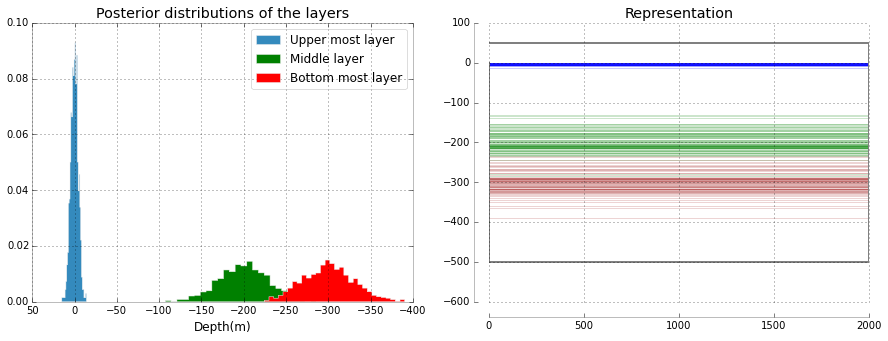

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(alpha_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Upper most layer", normed=True)
ax[0].hist(beta_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Middle layer", normed=True, color = "g")
ax[0].hist(gamma_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Bottom most layer", normed=True, color = "r")


ax[0].invert_xaxis()
ax[0].legend()
ax[0].set_title(r"""Posterior distributions of the layers""")
ax[0].set_xlabel("Depth(m)")


ax[1].set_title("Representation")
ax[1].set_xlim([0,2000])
for alpha, beta, gamma in parameters:
    #print alpha, beta, gamma
    model_parameters = {'faults' : {'fault_w_pos' : (0,0.),
                                    'fault_w_dip' : 0,
                                    'fault_e_pos' : (0.,0.),
                                    'fault_e_dip' : 0.},
                        'layers' : {3 : {'w' :(250., -200.),
                                         
                                                 'c' : (1000., -400.),
                                                 'e' : (1750., alpha)},
                                    2 : {'w' :(250., -400.),
                                                 'c' : (1000., -600.),
                                                 'e' : (1750., beta)},
                                    1 : {'w' :(250., -600.),
                                                 'c' : (1000., -800.),
                                                 'e' : (1750., gamma)}},
                        'layer_dip' : 0.000001,
                        'layer_colors' : {1 : 'Brown', 2 : 'g', 3 : 'b'},
                        'width' : 2000., # [m]
                        'height' : 500. # [m]
                        }
    GM = gs.GrabenModel(model_parameters)
    GM.plot_model(ax = ax[1], plot_faults= False, plot_points= False, alpha = 0.3) # Need to make it transparent!!!
plt.savefig("3 layers simple", dpi = 400, bbox_inches='tight', pad_inches=0)  

In [10]:
M.summary()


beta:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	[[-199.915]]     [[ 14.353]]      [[ 0.569]]   [-226.931 -173.611]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	[[-226.91]]      [[-210.514]]    [[-200.17]]    [[-188.941]]  [[-173.272]]
	

gamma:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	[[-300.235]]     [[ 13.8]]        [[ 0.474]]   [-330.612 -276.864]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	[[-329.336]]     [[-309.471]]    [[-299.525]]   [[-290.322]]  [[-275.212]]
	

alpha:
 
	Mean             SD               MC Error        95% HPD interval
	--------

Plotting beta
Plotting alpha
Plotting gamma


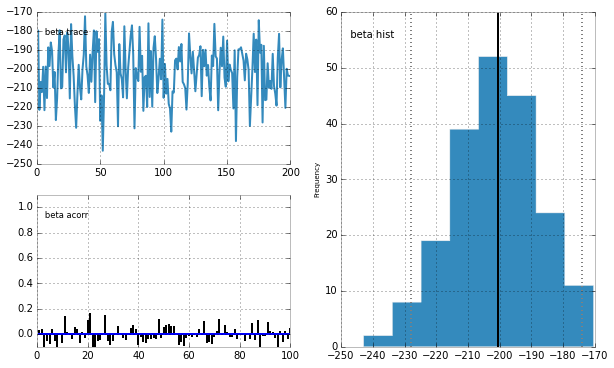

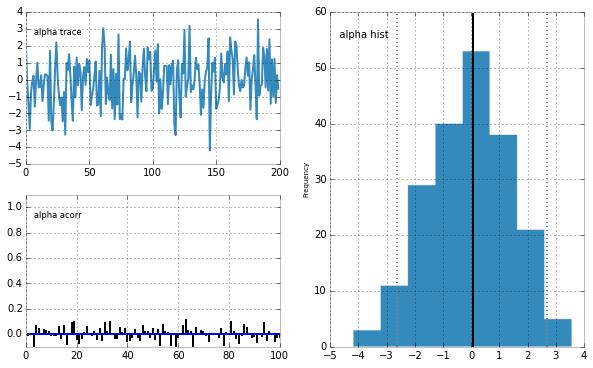

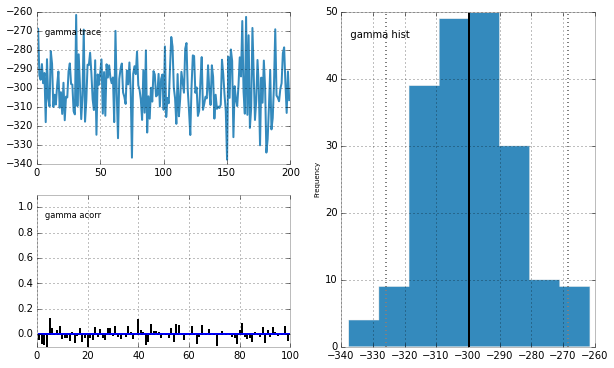

In [9]:
plot(M)

###Tickness of layers known
####Setting priors

In [11]:
alpha = pm.Normal("alpha", 0, 0.05)

thickness_layer1 = pm.Normal("thickness_layer1", 200, 0.01) # less uncertainty than before
thickness_layer2 = pm.Normal("thickness_layer2", 100, 0.01)



@pm.deterministic
def beta(alpha = alpha, thickness_layer1 = thickness_layer1):
    return alpha - thickness_layer1


@pm.deterministic
def gamma(beta = beta, thickness_layer2 = thickness_layer2):
    return beta - thickness_layer2


#MODEL!!
model = pm.Model([alpha, beta, gamma, thickness_layer1, thickness_layer2])

####PyMC simulation

In [12]:
M = pm.MCMC(model)
M.sample(iter=15000, burn = 800)

 [-----------------100%-----------------] 15000 of 15000 complete in 1.7 sec

####Representation

In [13]:
alpha_samples = M.trace('alpha')[:]
beta_samples = M.trace('beta')[:]
gamma_samples = M.trace('gamma')[:]

alpha_samples, alpha_samples_all = M.trace('alpha')[-40:], M.trace("alpha")[:]
beta_samples, beta_samples_all = M.trace('beta')[-40:], M.trace("beta")[:]
gamma_samples, gamma_samples_all = M.trace('gamma')[-40:], M.trace('gamma')[:]

parameters = zip(alpha_samples, beta_samples, gamma_samples)
parameters_all = zip(alpha_samples_all, beta_samples_all, gamma_samples_all)

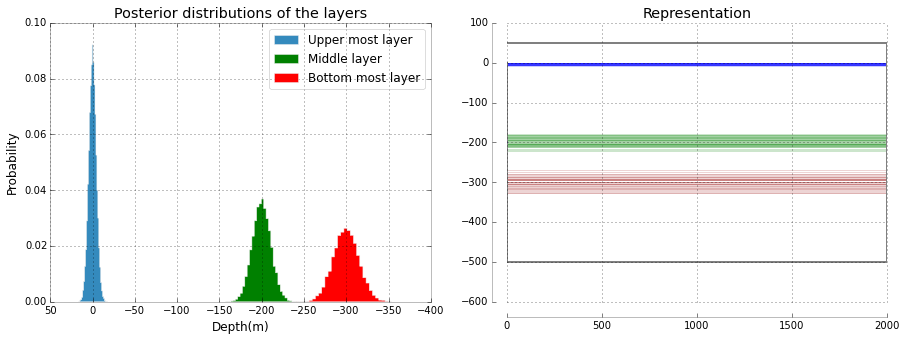

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(alpha_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Upper most layer", normed=True)
ax[0].hist(beta_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Middle layer", normed=True, color = "g")
ax[0].hist(gamma_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Bottom most layer", normed=True, color = "r")


ax[0].invert_xaxis()
ax[0].legend()
ax[0].set_title(r"""Posterior distributions of the layers""")
ax[0].set_xlabel("Depth(m)")
ax[0].set_ylabel("Probability")


ax[1].set_title("Representation")
ax[1].set_xlim([0,2000])
for alpha, beta, gamma in parameters:
    #print alpha, beta, gamma
    model_parameters = {'faults' : {'fault_w_pos' : (0,0.),
                                    'fault_w_dip' : 0,
                                    'fault_e_pos' : (0.,0.),
                                    'fault_e_dip' : 0.},
                        'layers' : {3 : {'w' :(250., -200.),
                                         
                                                 'c' : (1000., -400.),
                                                 'e' : (1750., alpha)},
                                    2 : {'w' :(250., -400.),
                                                 'c' : (1000., -600.),
                                                 'e' : (1750., beta)},
                                    1 : {'w' :(250., -600.),
                                                 'c' : (1000., -800.),
                                                 'e' : (1750., gamma)}},
                        'layer_dip' : 0.000001,
                        'layer_colors' : {1 : 'Brown', 2 : 'g', 3 : 'b'},
                        'width' : 2000., # [m]
                        'height' : 500. # [m]
                        }
    GM = gs.GrabenModel(model_parameters)
    GM.plot_model(ax = ax[1], plot_faults= False, plot_points= False, alpha = 0.3) # Need to make it transparent!!!

#ig.savefig("3layers", dpi = 200, bbox_inches = "tight")
plt.savefig("3 layers determin", dpi = 400, bbox_inches='tight', pad_inches=0)  

The uncertainty is additive!!

Plotting beta
Plotting alpha
Plotting gamma
Plotting thickness_layer2
Plotting thickness_layer1


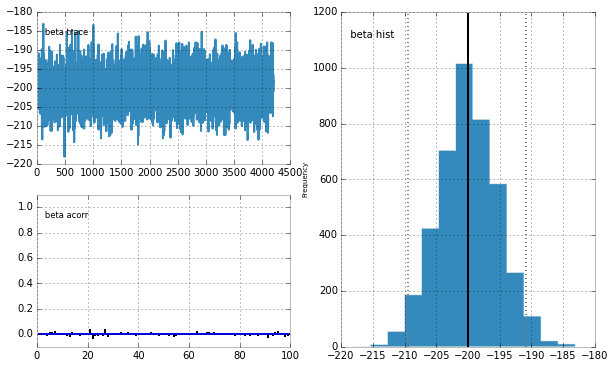

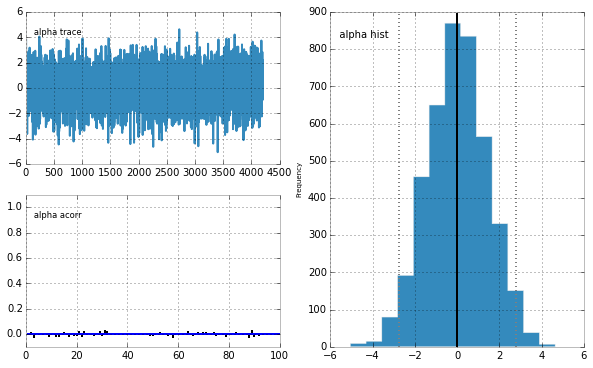

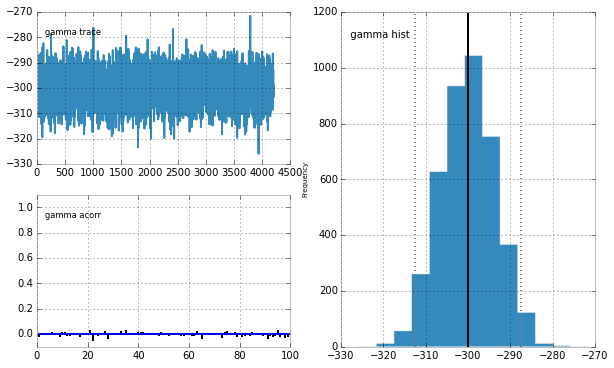

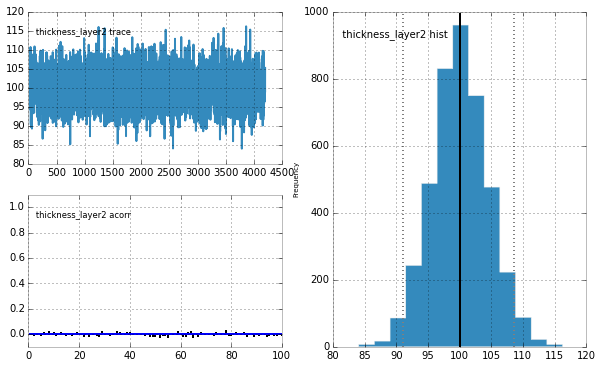

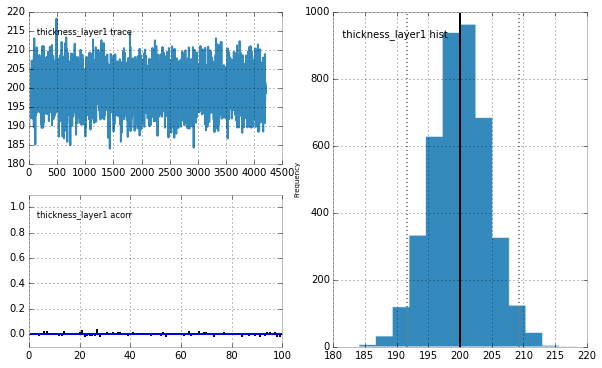

In [113]:
plot(M)

In [21]:
M.summary()


alpha:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	[[-0.021]]       [[ 1.433]]       [[ 0.022]]       [-2.968  2.671]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	[[-2.887]]       [[-0.966]]      [[-0.007]]     [[ 0.935]]    [[ 2.81]]
	

thickness_layer2:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	[[ 100.024]]     [[ 14.178]]      [[ 0.227]]   [  73.944  129.273]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	[[ 71.913]]      [[ 90.657]]     [[ 99.982]]    [[ 109.58]]   [[ 127.605]]
	

thickness_layer1:
 
	Mean             SD               MC Error        95% HP

### Adding complexity: Faults and slight inclination, no constraints

#### Setting priors and model

In [7]:
alpha = pm.Normal("alpha", 0, 0.5)

thickness_layer1 = pm.Normal("thickness_layer1", 200, 0.005)
thickness_layer2 = pm.Normal("thickness_layer2", 100, 0.005)

offset = pm.Normal("offset", 400, 0.05)
layer_dip = pm.Normal("layer_dip", 5, 0.05)

fault_e_dip = pm.Normal("fault_e_dip", -70, 0.00005)
fault_w_dip = pm.Normal("fault_w_dip", 70, 0.05)


@pm.deterministic
def beta(alpha = alpha, thickness_layer1 = thickness_layer1):
    return alpha - thickness_layer1


@pm.deterministic
def gamma(beta = beta, thickness_layer2 = thickness_layer2):
    return beta - thickness_layer2


#MODEL!!
model = pm.Model([alpha, beta, gamma, thickness_layer1, thickness_layer2, offset, layer_dip, fault_e_dip, fault_w_dip])

#### PyMC simulation

In [8]:
M = pm.MCMC(model)
M.sample(iter=5000, burn = 800)

 [-----------------100%-----------------] 5000 of 5000 complete in 1.2 sec

####Representation

In [9]:
gamma_samples, gamma_samples_all = M.trace('gamma')[-9:], M.trace('gamma')[:]
alpha_samples, alpha_samples_all = M.trace('alpha')[-9:], M.trace("alpha")[:]
beta_samples, beta_samples_all = M.trace('beta')[-9:], M.trace("beta")[:]
offset_samples, offset_samples_all = M.trace("offset")[-9:], M.trace("offset")[:]
layer_dip = M.trace("layer_dip")[-9:]
fault_e_dip = M.trace("fault_e_dip")[-9:]
fault_w_dip = M.trace("fault_w_dip")[-9:]

parameters = zip(alpha_samples, beta_samples, gamma_samples, offset_samples, layer_dip, fault_e_dip, fault_w_dip)
parameters_all = zip(alpha_samples_all, beta_samples_all, gamma_samples_all, offset_samples_all)

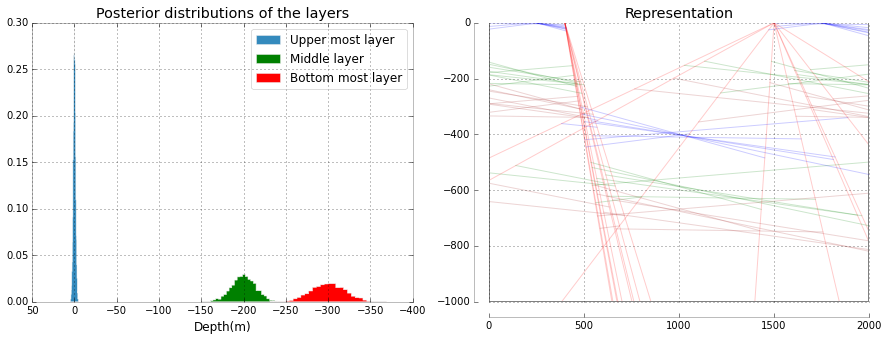

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(alpha_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Upper most layer", normed=True)
ax[0].hist(beta_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Middle layer", normed=True, color = "g")
ax[0].hist(gamma_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Bottom most layer", normed=True, color = "r")


ax[0].invert_xaxis()
ax[0].legend()
ax[0].set_title(r"""Posterior distributions of the layers""")
ax[0].set_xlabel("Depth(m)")


ax[1].set_title("Representation")
ax[1].set_xlim([0,2000])
ax[1].set_ylim([-1000,0])
for  alpha, beta, gamma, offset, layer_dip, fault_e_dip, fault_w_dip in parameters:
    #print alpha, beta, gamma
    model_parameters = {'faults' : {'fault_w_pos' : (400.,0.),
                                'fault_w_dip' : fault_w_dip,
                                'fault_e_pos' : (1500.,0.),
                                'fault_e_dip' : fault_e_dip},
                        'layers' : {3 : {'w' :(250., alpha),
                                                 'c' : (1000., alpha - offset),
                                                 'e' : (1750., alpha)},
                                    2 : {'w' :(250., beta),
                                                 'c' : (1000., beta-offset),
                                                 'e' : (1750., beta)},
                                    1 : {'w' :(250., gamma),
                                                 'c' : (1000., gamma - offset),
                                                 'e' : (1750., gamma)}},
                        'layer_dip' : layer_dip,
                        'layer_colors' : {1 : 'Brown', 2 : 'g', 3 : 'b'},
                        'width' : 2000., # [m]
                        'height' : 1000. # [m]
                        }
    GM = gs.GrabenModel(model_parameters)
    GM.plot_model(ax = ax[1], plot_faults= True , plot_points= False, alpha = 0.3) # Need to make it transparent!!!
    
  
    

In [48]:
def plot_figure(alpha, beta, gamma, offset, layer_dip, fault_e_dip, fault_w_dip, axe_position):
    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    
    model_parameters = {'faults' : {'fault_w_pos' : (400.,0.),
                                'fault_w_dip' : fault_w_dip,
                                'fault_e_pos' : (1500.,0.),
                                'fault_e_dip' : fault_e_dip},
                        'layers' : {3 : {'w' :(250., alpha),
                                                 'c' : (1000., alpha - offset),
                                                 'e' : (1750., alpha)},
                                    2 : {'w' :(250., beta),
                                                 'c' : (1000., beta-offset),
                                                 'e' : (1750., beta)},
                                    1 : {'w' :(250., gamma),
                                                 'c' : (1000., gamma - offset),
                                                 'e' : (1750., gamma)}},
                        'layer_dip' : layer_dip,
                        'layer_colors' : {1 : 'Brown', 2 : 'g', 3 : 'b'},
                        'width' : 2000., # [m]
                        'height' : 1000. # [m]
                        }
    GM = gs.GrabenModel(model_parameters)
    GM.plot_model(ax = axe_position, plot_faults= True, plot_points= False, alpha = 1) # Need to make it transparent!!! 
    plt.tight_layout()

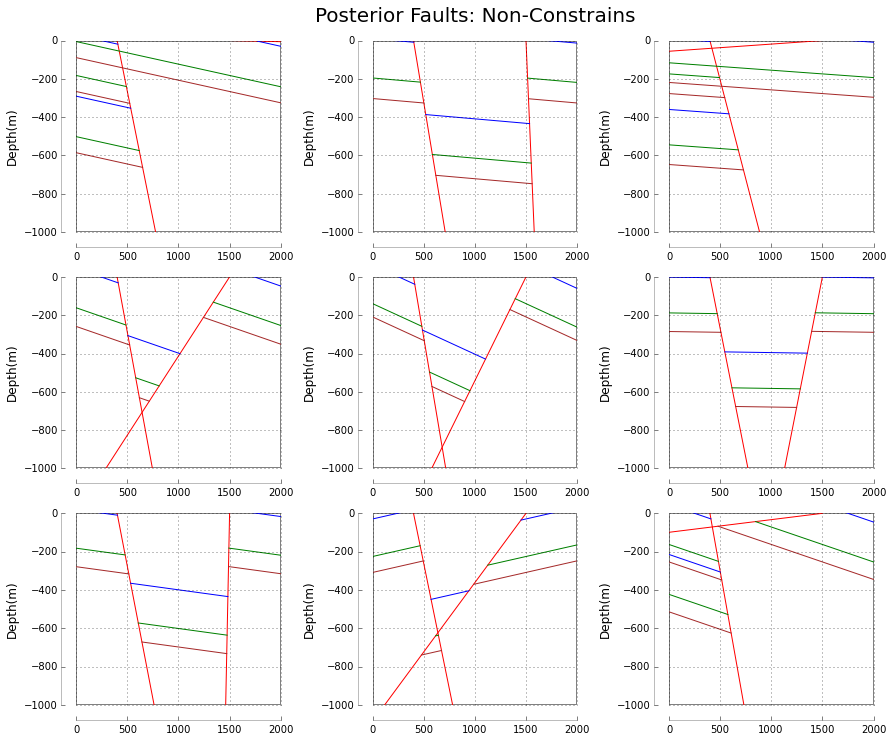

In [49]:
i = 0
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True)




plt.text(0.5, 1.1, "Posterior Faults: Non-Constrains",
     horizontalalignment='center',
        fontsize=20,
        transform = axs[0,1].transAxes)
#plt.subplots_adjust(top=2.15)
#axs[0,1].set_title("Posterior Faults: Non-Constrains", fontsize=20)

for alpha, beta, gamma, offset, layer_dip, fault_e_dip, fault_w_dip  in parameters:
   # ax = fig.add_subplot(111)
    plot_figure(alpha, beta, gamma, offset, layer_dip, fault_e_dip, fault_w_dip, axs[i- 3*(i/3),i/3])
    axs[i- 3*(i/3),i/3].set_xlim([0,2000])
    axs[i- 3*(i/3),i/3].set_ylim([-1000,0])
    axs[i- 3*(i/3),i/3].set_ylabel("Depth(m)")
    i += 1

plt.savefig("FaultsNoCon", dpi = 200, bbox_inches='tight', pad_inches=0.5)     

In [ ]:
plot(M)

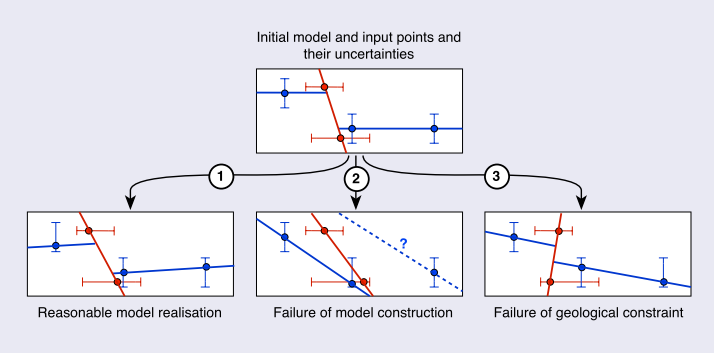

In [81]:
from IPython.core.display import Image
Image('Failures.png')

###Necessary constraints:
####Offset
- Negative offset makes no sense
- Higher values than the faults intersection

####Dipping
- Layers have to intersect in the 3 sectors: West, Center and East

#### Faults
- Numerical
 - The same as offset
 - Intersect -> same as dipping

- Geological
 - No more than 90º
 
### Adding complexity: Faults and slight inclination: Constraints
#### Setting priors and model

In [14]:
#Priors

alpha = pm.Normal("alpha", 0, 0.5)

thickness_layer1 = pm.Normal("thickness_layer1", 200, 0.005) # a lot of uncertainty so the constrains are necessary
thickness_layer2 = pm.Normal("thickness_layer2", 100, 0.005)

offset = pm.Normal("offset", 500, 0.005)
layer_dip = pm.Normal("layer_dip", 5, 0.05)

fault_e_dip = pm.Normal("fault_e_dip", -70, 0.005, value = -70)
fault_w_dip = pm.Normal("fault_w_dip", 70, 0.005, value = 70)


@pm.deterministic
def beta(alpha = alpha, thickness_layer1 = thickness_layer1):
    return alpha - thickness_layer1


@pm.deterministic
def gamma(beta = beta, thickness_layer2 = thickness_layer2):
    return beta - thickness_layer2

# Constraints -> probability

@pm.potential
def offset_negative_constraint(offset = offset):
    if offset < 0:
        return -np.inf
    return 0

@pm.potential
def faults_limits(fault_e_dip = fault_e_dip, fault_w_dip = fault_w_dip):
    if fault_e_dip < -90 or fault_w_dip > 90 :
        return -np.inf
    if fault_e_dip > 0 or fault_w_dip < 0:
        return -np.inf
    return 0


@pm.potential
def offset_below_faults_constraint(fault_e_dip = fault_e_dip, fault_w_dip = fault_w_dip,
                                   offset = offset, beta =  beta, gamma = gamma):
    fault_intersect = 1100/(np.tan(np.radians(90+fault_e_dip))+np.tan(np.radians(90-fault_w_dip)))       #1100 Distance of the faults at surface for now

#    print "fault",fault_intersect
 #   print  "layers", fault_intersect-offset-gamma, fault_intersect-offset-beta
    if (fault_intersect-offset-beta) < 0 or (fault_intersect-offset-gamma) < 0:
        return -np.inf
    else:
        return 0



#MODEL!!
model = pm.Model([alpha, beta, gamma, thickness_layer1, thickness_layer2,
                  offset, layer_dip, fault_e_dip, fault_w_dip, 
                  faults_limits, offset_negative_constraint, offset_below_faults_constraint])

#### PyMC simulation

In [20]:
M = pm.MCMC(model)
M.sample(iter=10000)
from pymc import graph

a = graph.dag(M)
a.write_png("Allparameters.png")

 [-----------------100%-----------------] 10000 of 10000 complete in 5.0 sec

True

Plotting alpha
Plotting fault_e_dip
Plotting layer_dip
Plotting offset
Plotting beta
Plotting gamma
Plotting fault_w_dip
Plotting thickness_layer2
Plotting thickness_layer1


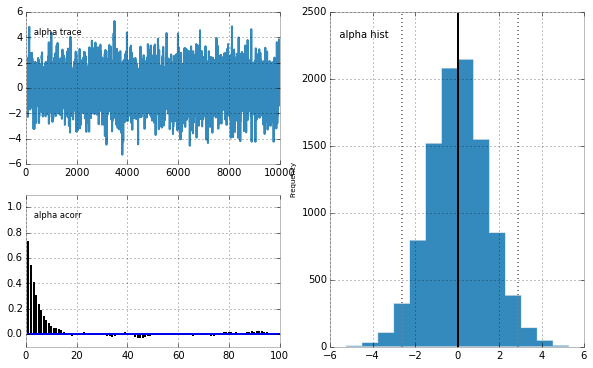

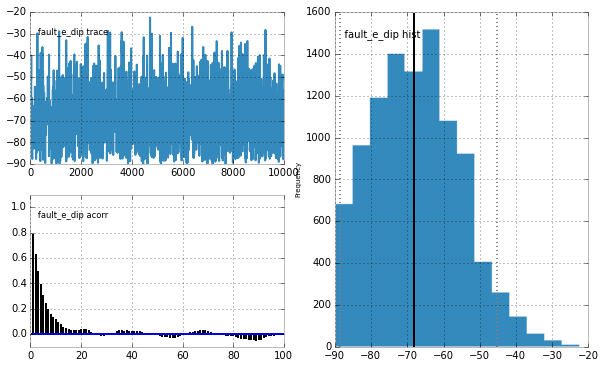

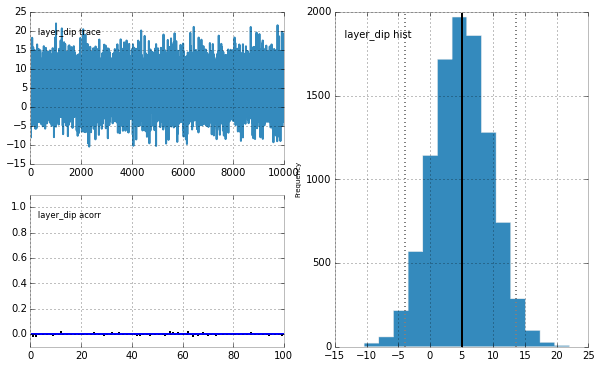

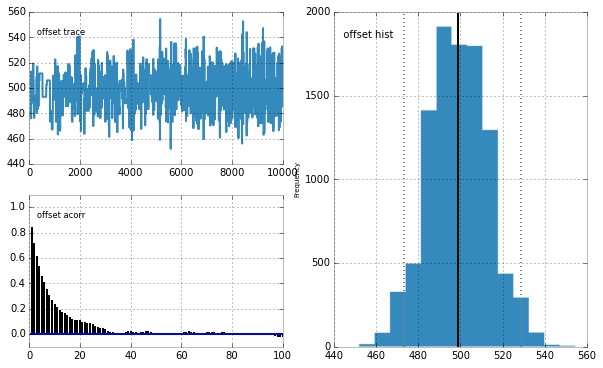

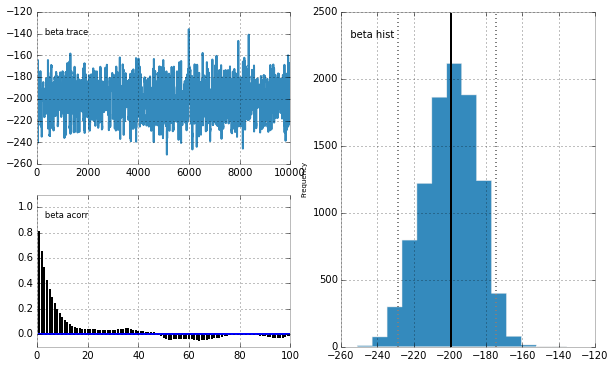

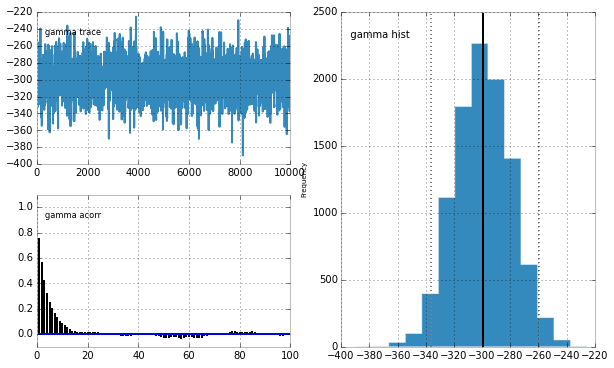

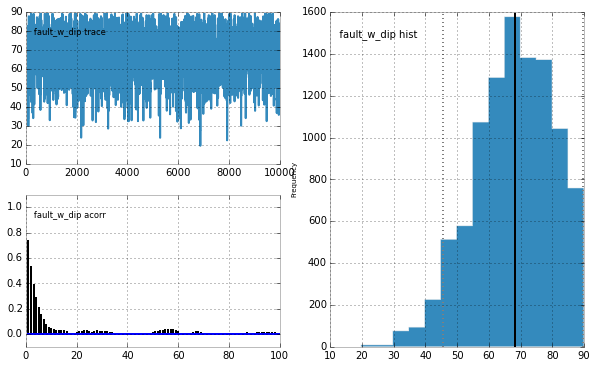

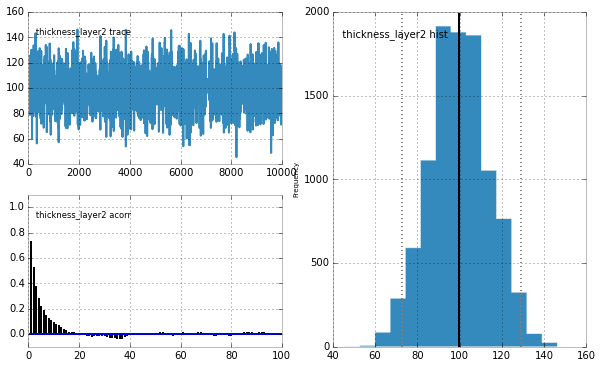

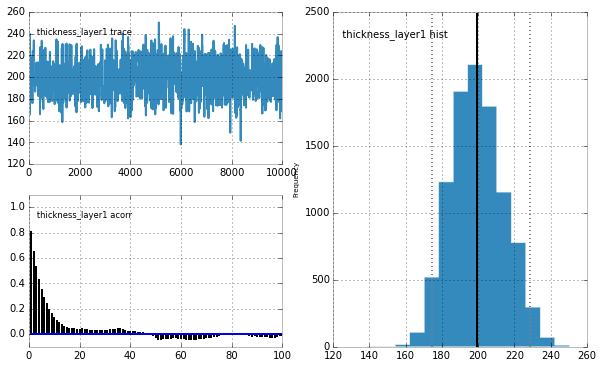

In [21]:
plot(M)

In [16]:
M.step_method_dict

{<pymc.distributions.Normal 'thickness_layer1' at 0x000000001A0DABE0>: [<pymc.StepMethods.Metropolis at 0x1a0da4e0>],
 <pymc.distributions.Normal 'thickness_layer2' at 0x000000001A039B70>: [<pymc.StepMethods.Metropolis at 0x1a0da4a8>],
 <pymc.distributions.Normal 'fault_w_dip' at 0x000000001A0DAC88>: [<pymc.StepMethods.Metropolis at 0x1a0da438>],
 <pymc.distributions.Normal 'offset' at 0x0000000019F05EB8>: [<pymc.StepMethods.Metropolis at 0x1a0da3c8>],
 <pymc.distributions.Normal 'layer_dip' at 0x0000000019FDCE80>: [<pymc.StepMethods.DrawFromPrior at 0x1a0da5c0>],
 <pymc.distributions.Normal 'fault_e_dip' at 0x000000001A0DAC50>: [<pymc.StepMethods.Metropolis at 0x1a0da358>],
 <pymc.distributions.Normal 'alpha' at 0x000000001A0DAC18>: [<pymc.StepMethods.Metropolis at 0x1a0dae10>]}

In [13]:
from pymc import graph

a = graph.dag(M)
a.write_png("a2.png")

True

#### Representation

In [29]:
s = -9

gamma_samples, gamma_samples_all = M.trace('gamma')[s:], M.trace('gamma')[:]
alpha_samples, alpha_samples_all = M.trace('alpha')[s:], M.trace("alpha")[:]
beta_samples, beta_samples_all = M.trace('beta')[s:], M.trace("beta")[:]
offset_samples, offset_samples_all = M.trace("offset")[s:], M.trace("offset")[:]

layer_dip, layer_dip_all = M.trace("layer_dip")[s:], M.trace("layer_dip")[:]
fault_e_dip, fault_e_dip_all = M.trace("fault_e_dip")[s:], M.trace("fault_e_dip")[:]


fault_w_dip, fault_w_dip_all = M.trace("fault_w_dip")[s:],M.trace("fault_w_dip")[:]

parameters = zip(alpha_samples, beta_samples, gamma_samples, offset_samples, layer_dip, fault_e_dip, fault_w_dip)
parameters_all = zip(alpha_samples_all, beta_samples_all, gamma_samples_all, offset_samples_all, layer_dip_all, fault_e_dip_all, fault_w_dip_all)

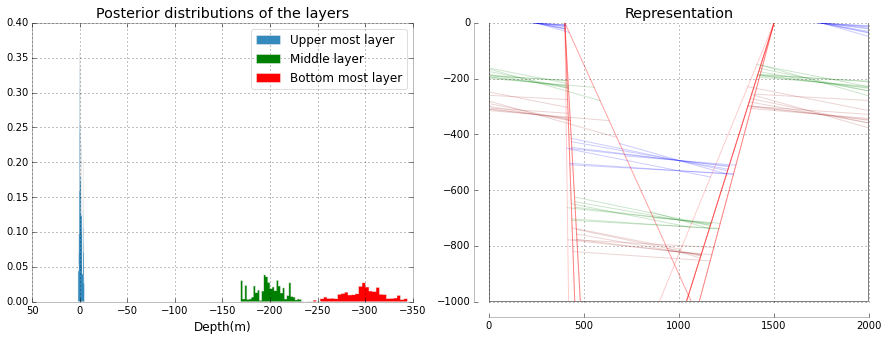

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(alpha_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Upper most layer", normed=True)
ax[0].hist(beta_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Middle layer", normed=True, color = "g")
ax[0].hist(gamma_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Bottom most layer", normed=True, color = "r")
#ax[0].hist(fault_e_dip_all, histtype='stepfilled', bins=30, alpha=1,
 #        label="Fault east dip", normed=True, color = "y")

ax[0].invert_xaxis()
ax[0].legend()
ax[0].set_title(r"""Posterior distributions of the layers""")
ax[0].set_xlabel("Depth(m)")


ax[1].set_title("Representation")
ax[1].set_xlim([0,2000])
ax[1].set_ylim([-1000,0])
for  alpha, beta, gamma, offset, layer_dip, fault_e_dip, fault_w_dip in parameters:
    #print alpha, beta, gamma
    model_parameters = {'faults' : {'fault_w_pos' : (400.,0.),
                                'fault_w_dip' : fault_w_dip,
                                'fault_e_pos' : (1500.,0.),
                                'fault_e_dip' : fault_e_dip},
                        'layers' : {3 : {'w' :(250., alpha),
                                                 'c' : (1000., alpha - offset),
                                                 'e' : (1750., alpha)},
                                    2 : {'w' :(250., beta),
                                                 'c' : (1000., beta-offset),
                                                 'e' : (1750., beta)},
                                    1 : {'w' :(250., gamma),
                                                 'c' : (1000., gamma - offset),
                                                 'e' : (1750., gamma)}},
                        'layer_dip' : layer_dip,
                        'layer_colors' : {1 : 'Brown', 2 : 'g', 3 : 'b'},
                        'width' : 2000., # [m]
                        'height' : 1000. # [m]
                        }
    GM = gs.GrabenModel(model_parameters)
    GM.plot_model(ax = ax[1], plot_faults= True , plot_points= False, alpha = 0.3) # Need to make it transparent!!!

In [42]:
def plot_figure(alpha, beta, gamma, offset, layer_dip, fault_e_dip, fault_w_dip, axe_position):
    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    
    model_parameters = {'faults' : {'fault_w_pos' : (400.,0.),
                                'fault_w_dip' : fault_w_dip,
                                'fault_e_pos' : (1500.,0.),
                                'fault_e_dip' : fault_e_dip},
                        'layers' : {3 : {'w' :(250., alpha),
                                                 'c' : (1000., alpha - offset),
                                                 'e' : (1750., alpha)},
                                    2 : {'w' :(250., beta),
                                                 'c' : (1000., beta-offset),
                                                 'e' : (1750., beta)},
                                    1 : {'w' :(250., gamma),
                                                 'c' : (1000., gamma - offset),
                                                 'e' : (1750., gamma)}},
                        'layer_dip' : layer_dip,
                        'layer_colors' : {1 : 'Brown', 2 : 'g', 3 : 'b'},
                        'width' : 2000., # [m]
                        'height' : 1000. # [m]
                        }
    GM = gs.GrabenModel(model_parameters)
    GM.plot_model(ax = axe_position, plot_faults= True, plot_points= False, alpha = 1) # Need to make it transparent!!! 
    plt.tight_layout()

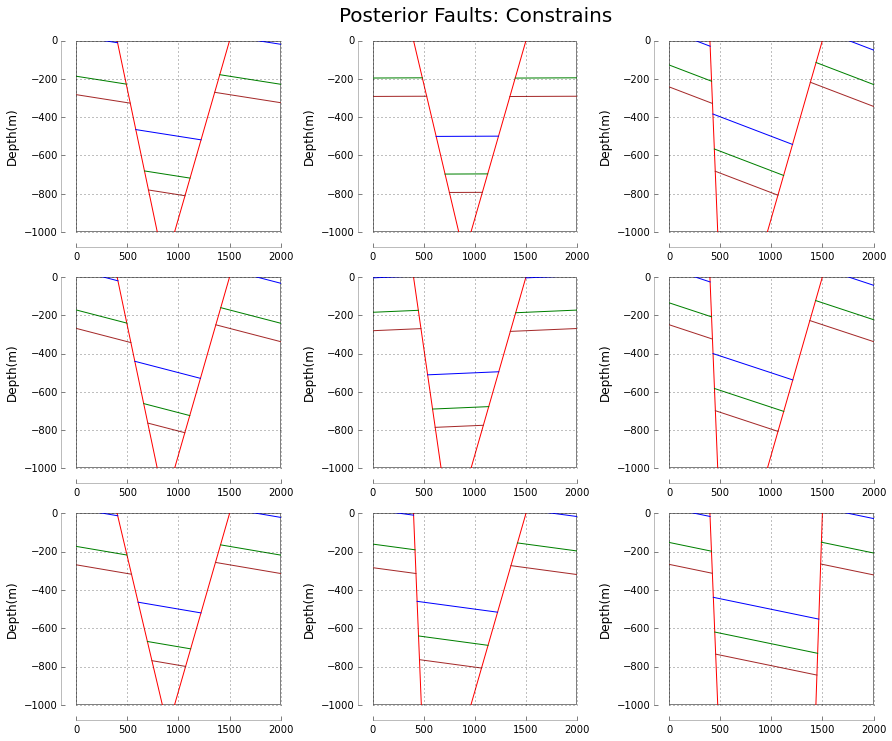

In [43]:
i = 0
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True)




plt.text(0.5, 1.1, "Posterior Faults: Constrains",
     horizontalalignment='center',
        fontsize=20,
        transform = axs[0,1].transAxes)
#plt.subplots_adjust(top=2.15)
#axs[0,1].set_title("Posterior Faults: Non-Constrains", fontsize=20)

for alpha, beta, gamma, offset, layer_dip, fault_e_dip, fault_w_dip  in parameters:
   # ax = fig.add_subplot(111)
    plot_figure(alpha, beta, gamma, offset, layer_dip, fault_e_dip, fault_w_dip, axs[i- 3*(i/3),i/3])
    axs[i- 3*(i/3),i/3].set_xlim([0,2000])
    axs[i- 3*(i/3),i/3].set_ylim([-1000,0])
    axs[i- 3*(i/3),i/3].set_ylabel("Depth(m)")
    i += 1

plt.savefig("FaultsCon", dpi = 200, bbox_inches='tight', pad_inches=0.5)     

In [22]:
pm.Poisson?

In [ ]:
plot(M)

Autocorrelation is a measure of how much the value of a signal correlates to other values of that signal at different points in time. In the context of MCMC, autocorrelation is a measure of how independent different samples from your posterior distribution are – lower autocorrelation indicating more independent results.

When you have high autocorrelation the samples you've drawn don't accurately represent the posterior distribution and therefore don't provide as meaningful information for the solution to the problem. In other words, lower autocorrelation means higher efficiency in your chains and better estimates. A general rule would be that the lower your autocorrelation, the less samples you need for the method to be effective (but that might be oversimplifying).

In [34]:
M.summary() #50 Iterations


beta:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	[[-208.696]]     [[ 6.904]]       [[ 0.976]]   [-216.518 -196.757]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	[[-216.91]]      [[-214.206]]    [[-211.732]]   [[-205.882]]  [[-197.079]]
	

fault_e_dip:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	[[-69.193]]      [[ 8.402]]       [[ 1.188]]     [-80.124 -59.05 ]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	[[-87.326]]      [[-76.613]]     [[-72.715]]    [[-60.604]]   [[-59.05]]
	

gamma:
 
	Mean             SD               MC Error        95% HPD interval
	----

In [39]:
M.summary() # 5000 iterations


beta:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	[[-199.784]]     [[ 15.125]]      [[ 0.718]]   [-227.042 -171.637]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	[[-227.415]]     [[-210.827]]    [[-199.419]]   [[-188.796]]  [[-171.909]]
	

fault_e_dip:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	[[-67.312]]      [[ 12.467]]      [[ 0.465]]     [-89.929 -45.126]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	[[-88.233]]      [[-77.007]]     [[-68.482]]    [[-58.608]]   [[-41.182]]
	

gamma:
 
	Mean             SD               MC Error        95% HPD interval
	---

## Model checking

#### Geweke

 first, proposed by [***Geweke*** (1992)](http://projecteuclid.org/DPubS?service=UI&version=1.0&verb=Display&handle=euclid.ss/1177011446), is a time-series approach that
compares the mean and variance of segments from the beginning and end of
a single chain.

$$z = \frac{\bar{\theta}_a - \bar{\theta}_b}{\sqrt{Var(\theta_a) + Var(\theta_b)}}$$

where $a$ is the early interval and $b$ the late interval. If the
z-scores (theoretically distributed as standard normal variates) of
these two segments are similar, it can provide evidence for convergence.
PyMC calculates z-scores of the difference between various initial
segments along the chain, and the last 50% of the remaining chain. If
the chain has converged, the majority of points should fall within 2
standard deviations of zero.

In PyMC, diagnostic z-scores can be obtained by calling the `geweke` function. It
accepts either (1) a single trace, (2) a Node or Stochastic object, or
(4) an entire Model object:


The arguments expected are the following:

-   `pymc_object`: The object that is or contains the output trace(s).

-   `first` (optional): First portion of chain to be used in Geweke
    diagnostic. Defaults to 0.1 (*i.e.* first 10% of chain).

-   `last` (optional): Last portion of chain to be used in Geweke
    diagnostic. Defaults to 0.5 (*i.e.* last 50% of chain).

-   `intervals` (optional): Number of sub-chains to analyze. Defaults to
    20.

The resulting scores are best interpreted graphically, using the
`geweke_plot` function. This displays the scores in series, in relation
to the 2 standard deviation boundaries around zero. Hence, it is easy to
see departures from the standard normal assumption.

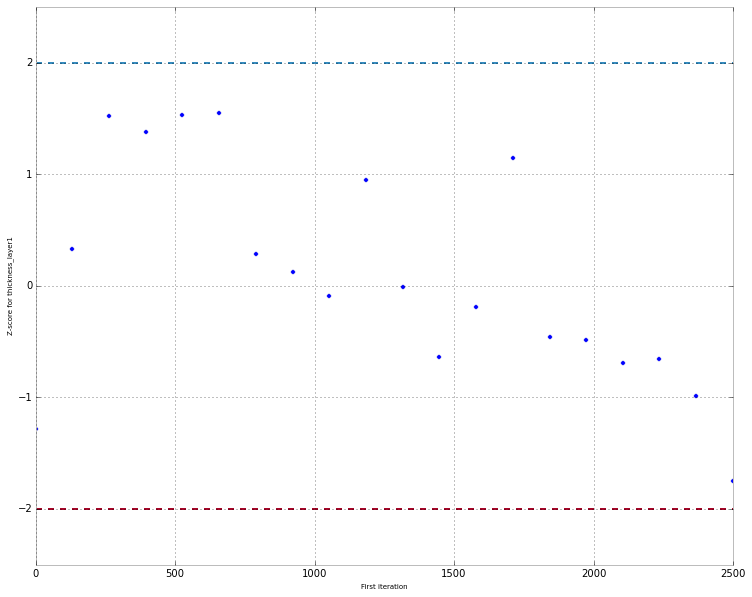

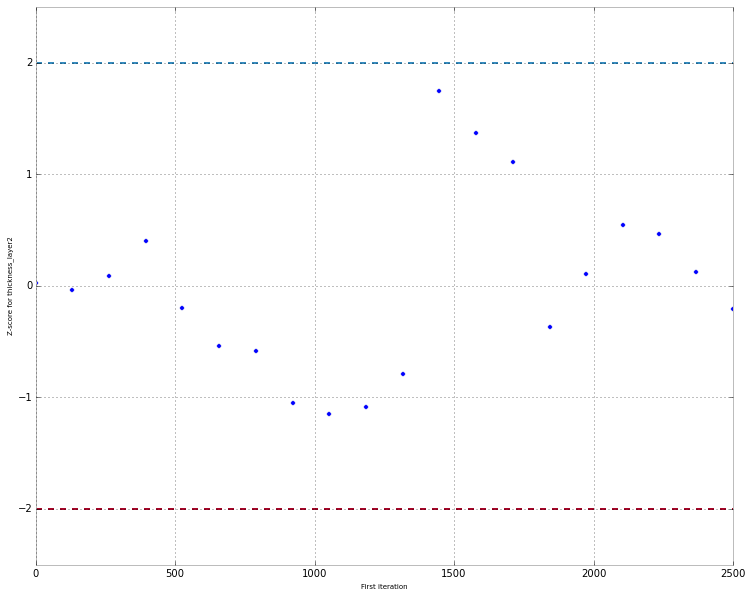

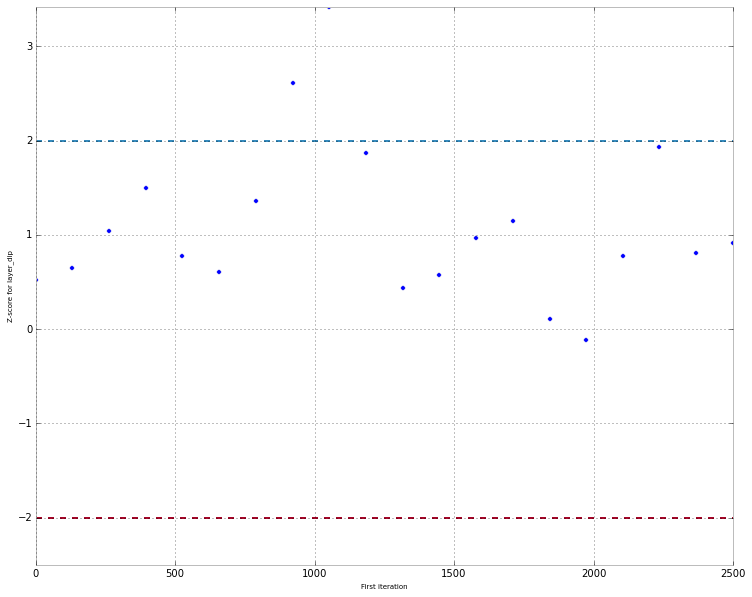

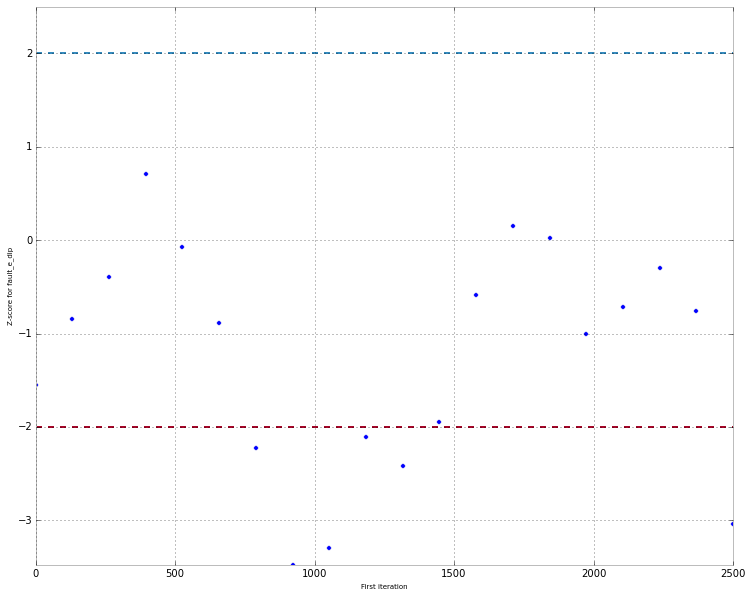

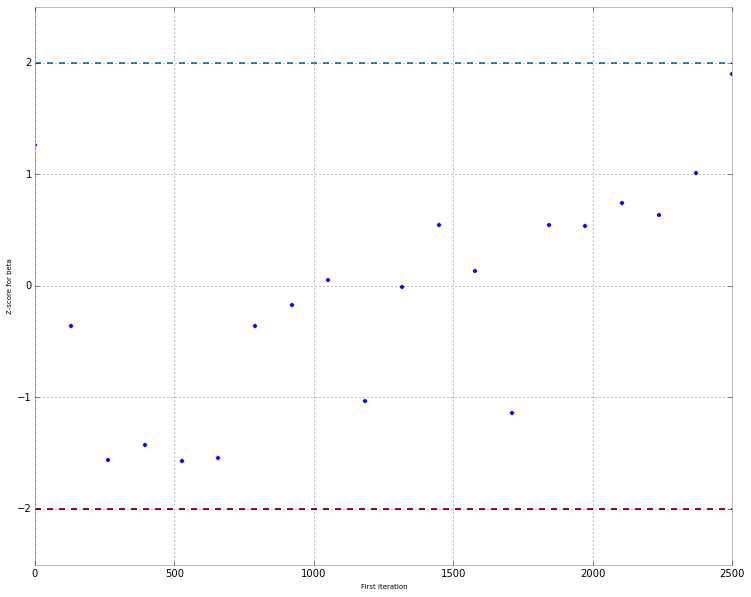

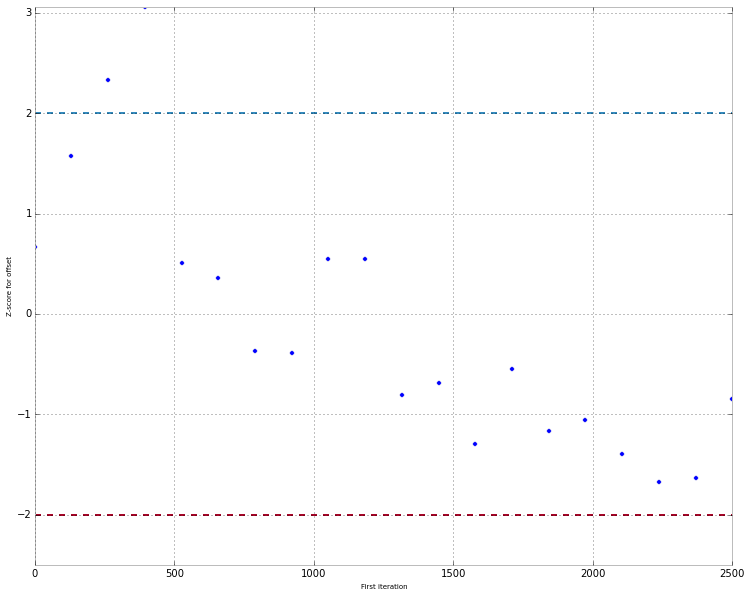

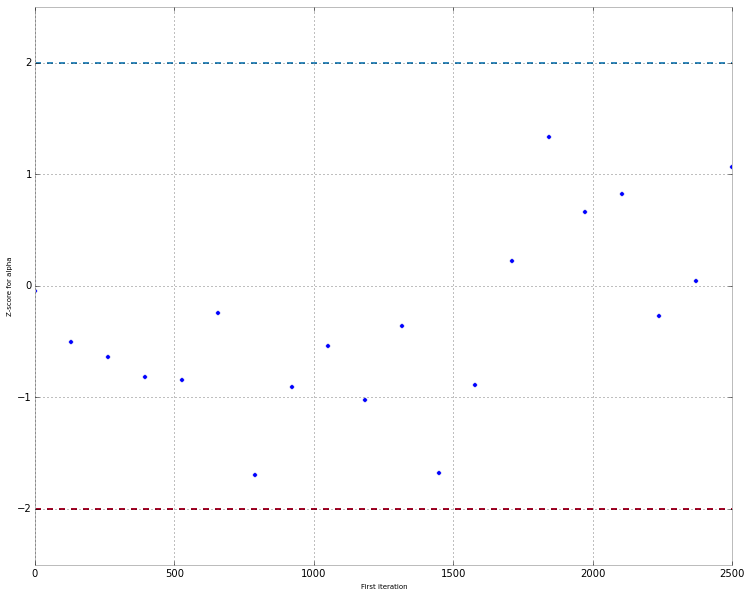

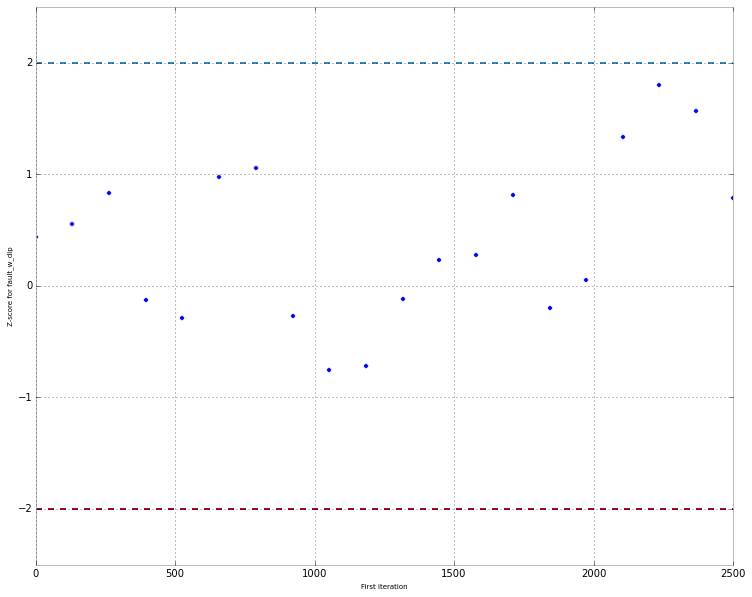

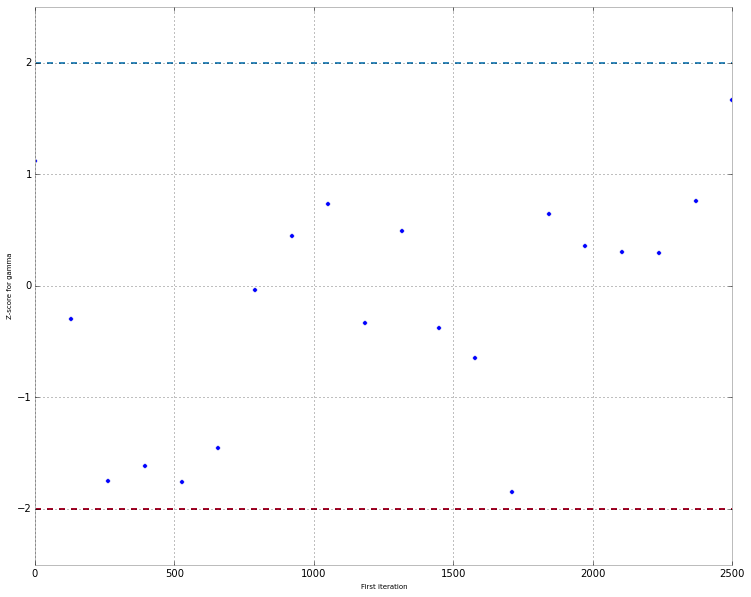

In [56]:
d = pm.geweke(M, intervals=20)
pm.Matplot.geweke_plot(d)

#### Raftery and Lewis


The second diagnostic provided by PyMC is the [***Raftery and Lewis*** (1992)](http://projecteuclid.org/DPubS?service=UI&version=1.0&verb=Display&handle=euclid.ss/1177011143)
procedure. This approach estimates the number of iterations required to
reach convergence, along with the number of burn-in samples to be
discarded and the appropriate thinning interval. A separate estimate of
both quantities can be obtained for each variable in a given model.

As the criterion for determining convergence, the Raftery and Lewis
approach uses the accuracy of estimation of a user-specified quantile.
For example, we may want to estimate the quantile $q=0.975$ to within
$r=0.005$ with probability $s=0.95$. In other words,

$$Pr(|\hat{q}-q| \le r) = s$$

From any sample of $\theta$, one can construct a binary chain:

$$Z^{(j)} = I(\theta^{(j)} \le u_q)$$

where $u_q$ is the quantile value and $I$ is the indicator function.
While $\{\theta^{(j)}\}$ is a Markov chain, $\{Z^{(j)}\}$ is not
necessarily so. In any case, the serial dependency among $Z^{(j)}$
decreases as the thinning interval $k$ increases. A value of $k$ is
chosen to be the smallest value such that the first order Markov chain
is preferable to the second order Markov chain.

This thinned sample is used to determine number of burn-in samples. This
is done by comparing the remaining samples from burn-in intervals of
increasing length to the limiting distribution of the chain. An
appropriate value is one for which the truncated sample's distribution
is within $\epsilon$ (arbitrarily small) of the limiting distribution.
Estimates for sample size tend to be conservative.

This diagnostic is best used on a short pilot run of a particular model,
and the results used to parameterize a subsequent sample that is to be
used for inference. 

In [64]:
pm.raftery_lewis(M, q=0.025, r=0.01)


Raftery-Lewis Diagnostic

937 iterations required (assuming independence) to achieve 0.01 accuracy with 95 percent probability.

Thinning factor of 1 required to produce a first-order Markov chain.

29 iterations to be discarded at the beginning of the simulation (burn-in).

7780 subsequent iterations required.

Thinning factor of 8 required to produce an independence chain.

Raftery-Lewis Diagnostic

937 iterations required (assuming independence) to achieve 0.01 accuracy with 95 percent probability.

Thinning factor of 1 required to produce a first-order Markov chain.

30 iterations to be discarded at the beginning of the simulation (burn-in).

8387 subsequent iterations required.

Thinning factor of 7 required to produce an independence chain.

Raftery-Lewis Diagnostic

937 iterations required (assuming independence) to achieve 0.01 accuracy with 95 percent probability.

Thinning factor of 1 required to produce a first-order Markov chain.

19 iterations to be discarded at the begin

{'alpha': (937, 1, 17, 4665, 7),
 'beta': (937, 1, 29, 7780, 8),
 'fault_e_dip': (937, 1, 30, 8387, 7),
 'fault_w_dip': (937, 1, 23, 6166, 7),
 'gamma': (937, 1, 19, 5160, 7),
 'layer_dip': (937, 1, 2, 963, 1),
 'offset': (937, 1, 61, 17740, 13),
 'thickness_layer1': (937, 1, 33, 10477, 9),
 'thickness_layer2': (937, 1, 24, 6568, 5)}

####Gelamn and Rubin

The third convergence diagnostic provided by PyMC is the ***Gelman-Rubin
statistic*** [Gelman and Rubin (1992)](http://projecteuclid.org/DPubS?service=UI&version=1.0&verb=Display&handle=euclid.ss/1177011136). This diagnostic uses multiple chains to
check for lack of convergence, and is based on the notion that if
multiple chains have converged, by definition they should appear very
similar to one another; if not, one or more of the chains has failed to
converge.

The Gelman-Rubin diagnostic uses an analysis of variance approach to
assessing convergence. That is, it calculates both the between-chain
varaince (B) and within-chain varaince (W), and assesses whether they
are different enough to worry about convergence. Assuming $m$ chains,
each of length $n$, quantities are calculated by:

$$\begin{align}B &= \frac{n}{m-1} \sum_{j=1}^m (\bar{\theta}_{.j} - \bar{\theta}_{..})^2 \\
W &= \frac{1}{m} \sum_{j=1}^m \left[ \frac{1}{n-1} \sum_{i=1}^n (\theta_{ij} - \bar{\theta}_{.j})^2 \right]
\end{align}$$

for each scalar estimand $\theta$. Using these values, an estimate of
the marginal posterior variance of $\theta$ can be calculated:

$$\hat{\text{Var}}(\theta | y) = \frac{n-1}{n} W + \frac{1}{n} B$$

Assuming $\theta$ was initialized to arbitrary starting points in each
chain, this quantity will overestimate the true marginal posterior
variance. At the same time, $W$ will tend to underestimate the
within-chain variance early in the sampling run. However, in the limit
as $n \rightarrow 
\infty$, both quantities will converge to the true variance of $\theta$.
In light of this, the Gelman-Rubin statistic monitors convergence using
the ratio:

$$\hat{R} = \sqrt{\frac{\hat{\text{Var}}(\theta | y)}{W}}$$

This is called the potential scale reduction, since it is an estimate of
the potential reduction in the scale of $\theta$ as the number of
simulations tends to infinity. In practice, we look for values of
$\hat{R}$ close to one (say, less than 1.1) to be confident that a
particular estimand has converged. In PyMC, the function
\`gelman\_rubin\` will calculate $\hat{R}$ for each stochastic node in
the passed model:

In [67]:
N = pm.MCMC(model)

N.sample(1000)
N.sample(1000)

 [-----------------100%-----------------] 1000 of 1000 complete in 0.5 sec

In [68]:
pm.gelman_rubin(N)

{'alpha': 1.029152628105412,
 'beta': 1.0040727733054506,
 'fault_e_dip': 1.0082811551358124,
 'fault_w_dip': 0.99902999043010798,
 'gamma': 1.0190297813013023,
 'layer_dip': 0.99992189067440407,
 'offset': 1.0290002288639204,
 'thickness_layer1': 1.0020834947961015,
 'thickness_layer2': 1.0138282325153587}

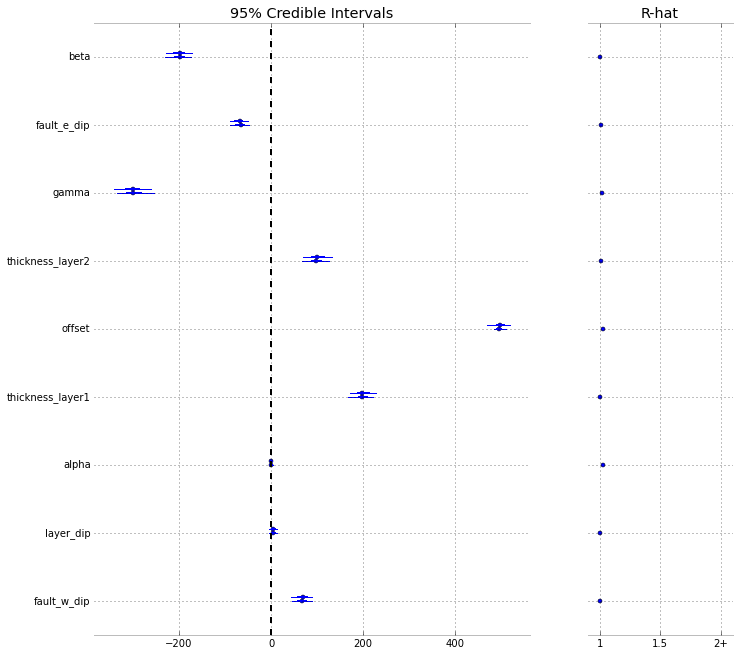

In [69]:
pm.Matplot.summary_plot(M)

## Correlation

Plotting beta
Plotting fault_e_dip
Plotting gamma
Plotting thickness_layer2
Plotting offset
Plotting thickness_layer1
Plotting alpha
Plotting layer_dip
Plotting fault_w_dip


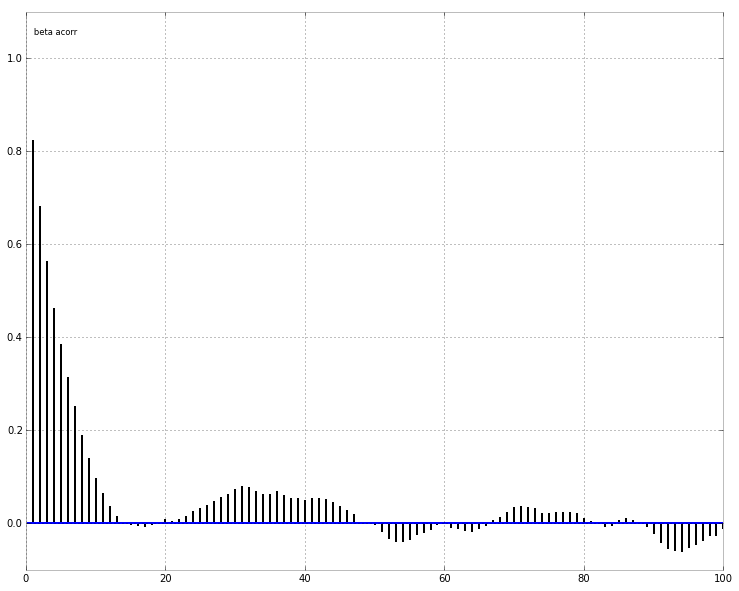

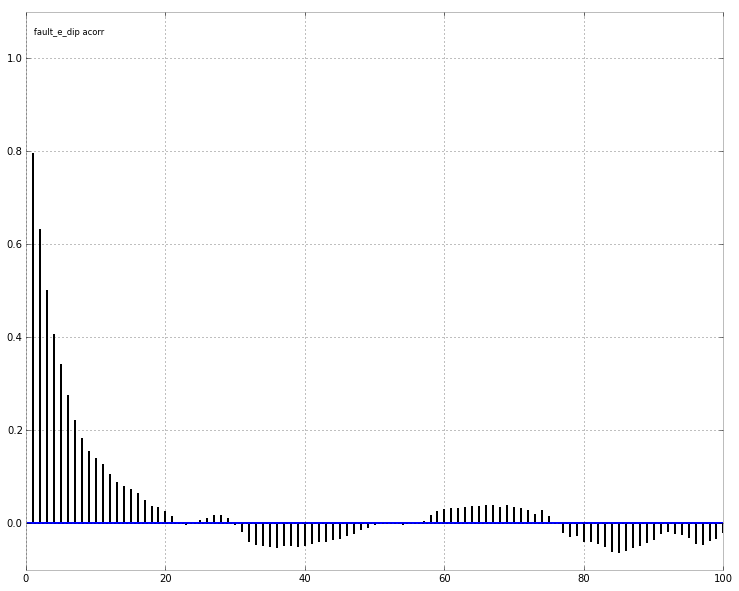

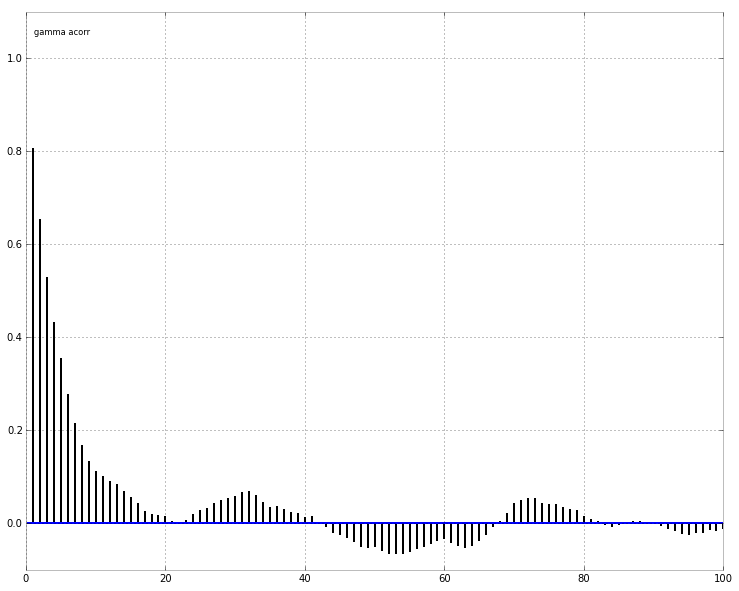

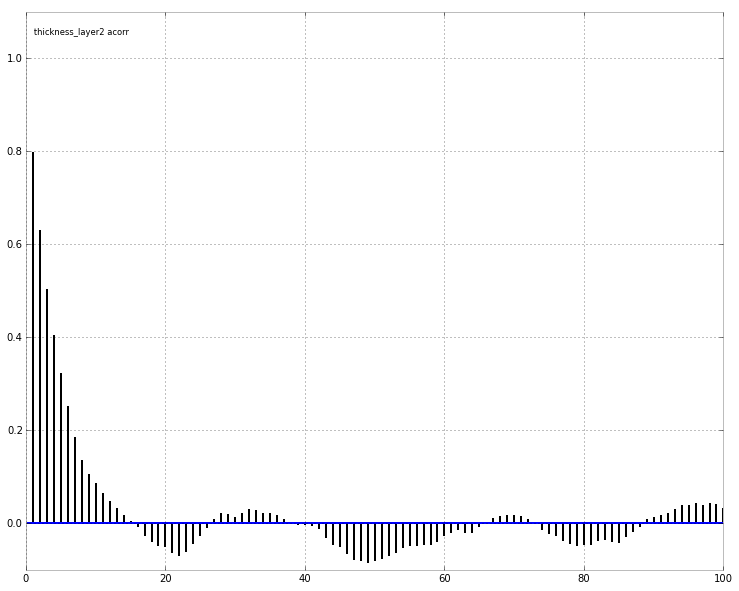

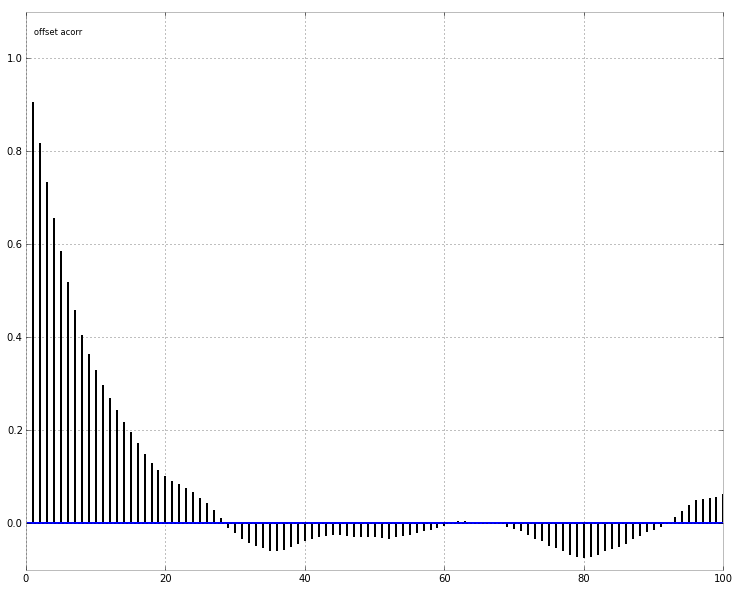

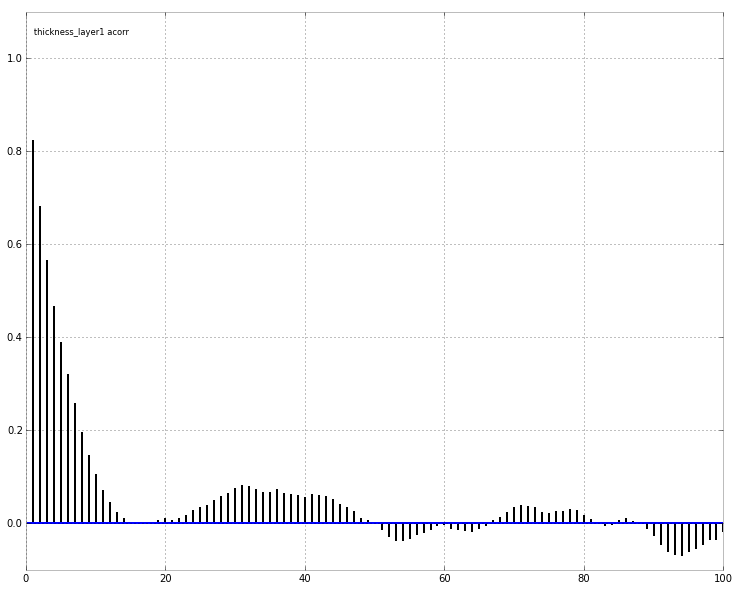

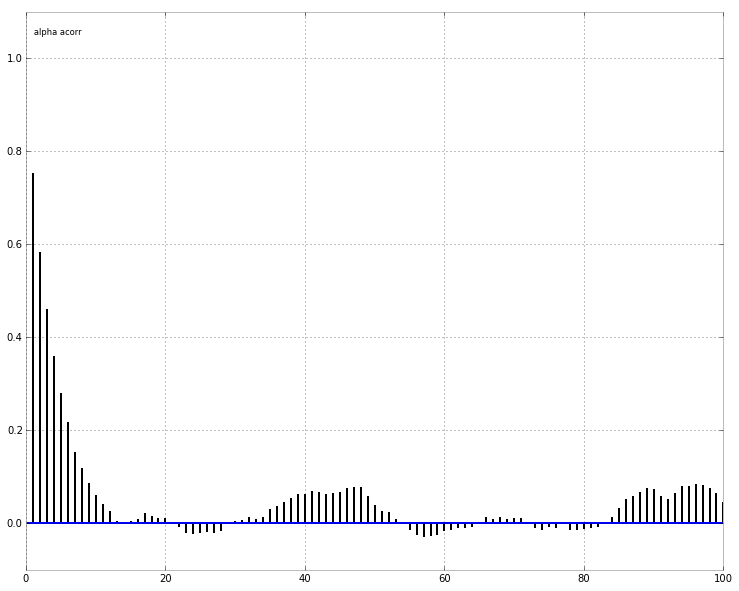

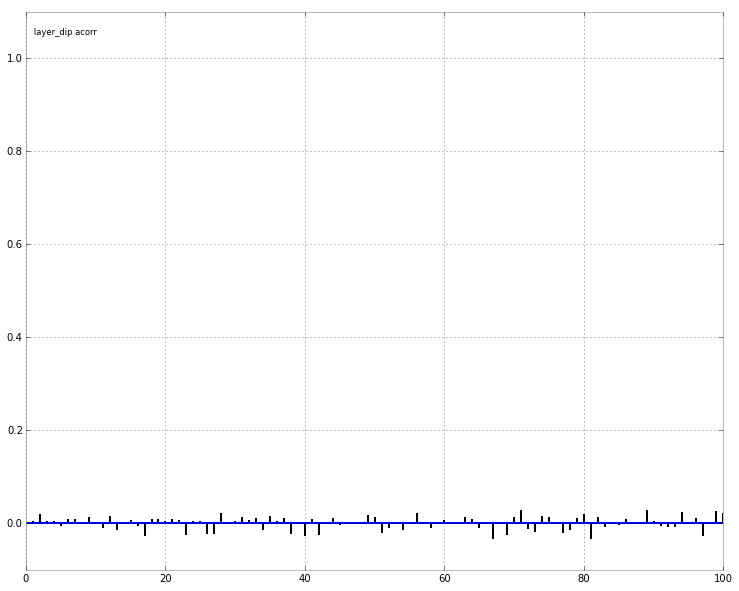

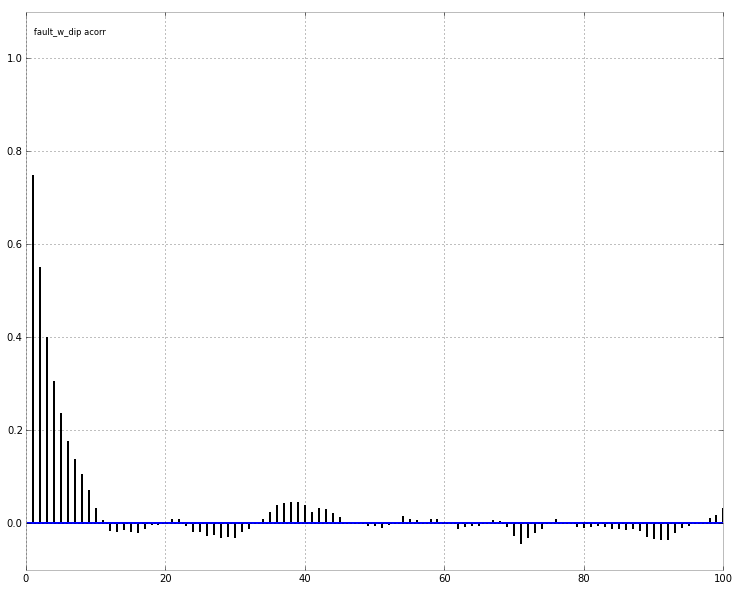

In [70]:
pm.Matplot.autocorrelation(M)

## Adding observed data

I want to make the position of alpha and its dip dependent of observed data. We set as prior normal distributions for both but we want to know the mean and tau of both values isn't it?

So the hard data we get are position of alpha in 2D and some dips, that is what we set in the geomodeller I guess. So lets create the synthetic data:

(4L,)


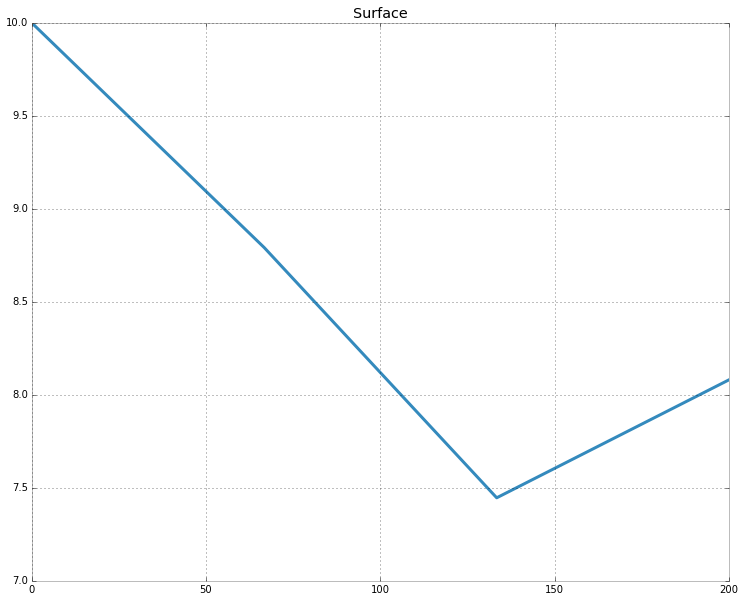

In [7]:
alpha_position_x = np.linspace(0,200,4)
alpha_position_y = np.ones(4)*10
print np.shape(alpha_position_x)
for i in range(1, 4):
    alpha_position_y[i] = pm.rnormal(alpha_position_y[i - 1], 2)
plt.plot(alpha_position_x, alpha_position_y, lw=3)
plt.title("Surface")

In [9]:

alpha = pm.Normal("alpha", 0,0.0001)  # Big uncertainty prior

thickness_layer1 = pm.Normal("thickness_layer1", 200, 0.05) # less uncertainty than before
thickness_layer2 = pm.Normal("thickness_layer2", 100, 0.05)



@pm.deterministic
def beta(alpha = alpha, thickness_layer1 = thickness_layer1):
    return alpha - thickness_layer1


@pm.deterministic
def gamma(beta = beta, thickness_layer2 = thickness_layer2):
    return beta - thickness_layer2

#@om.deterministic
#def observed(alpha= alpha)



observed = pm.Normal("obs", beta, 0.1,  value = alpha_position_y, observed = True)




#MODEL!!
model = pm.Model([ alpha, beta, gamma,observed, thickness_layer1, thickness_layer2])

####Simulation

In [10]:
M = pm.MCMC(model)

M.sample(iter=5000, burn = 80)


 [-----------------100%-----------------] 5000 of 5000 complete in 1.1 sec

Plotting thickness_layer2
Plotting alpha
Plotting gamma
Plotting thickness_layer1
Plotting beta


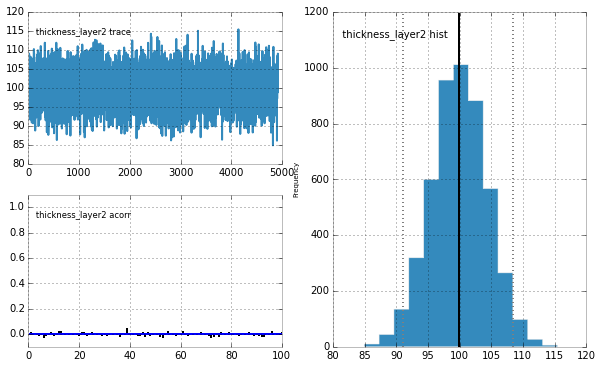

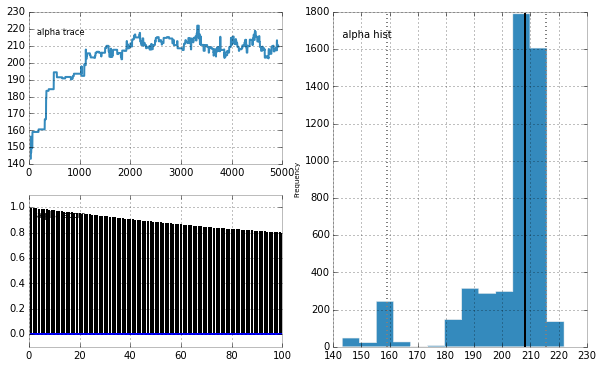

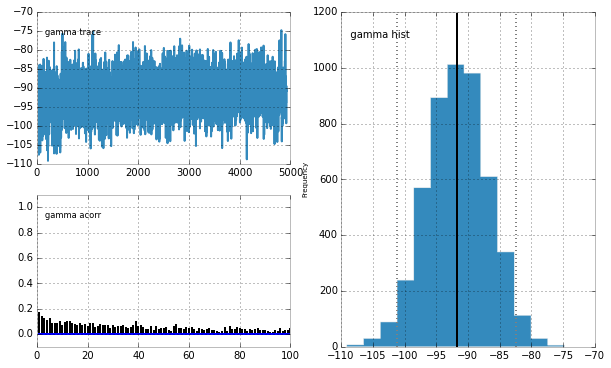

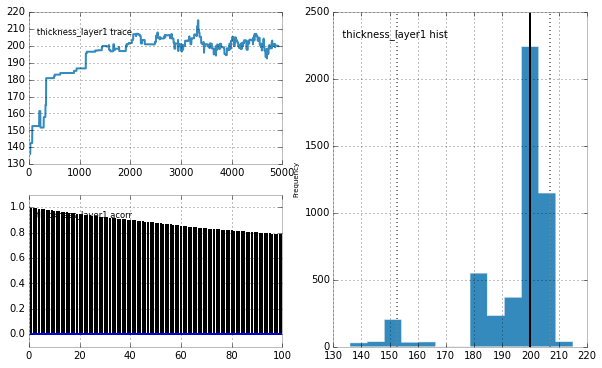

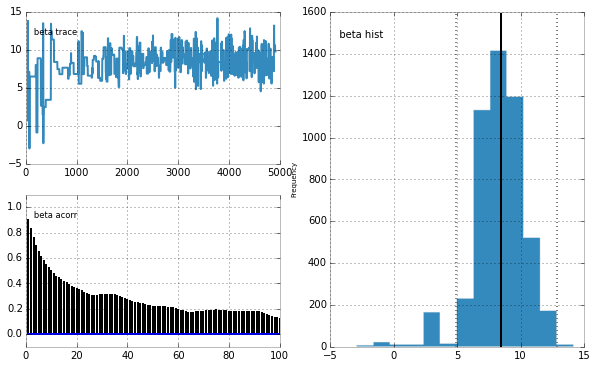

In [11]:
plot(M)

In [14]:
from pymc import graph, MCMC

a = graph.dag(M)
a.write_png("a3.png")

True

In [30]:
M.summary()


gamma:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	[[-299.802]]     [[ 14.129]]      [[ 0.217]]   [-326.663 -271.827]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	[[-327.571]]     [[-309.167]]    [[-299.819]]   [[-290.271]]  [[-272.384]]
	

alpha:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	[[ 0.223]]       [[ 1.504]]       [[ 0.078]]       [-2.649  3.221]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	[[-2.585]]       [[-0.647]]      [[ 0.099]]     [[ 1.063]]    [[ 3.357]]
	

beta:
 
	Mean             SD               MC Error        95% HPD interval
	----------

In [12]:
alpha_samples, alpha_samples_all = M.trace('alpha')[-80:], M.trace("alpha")[:]
beta_samples, beta_samples_all = M.trace('beta')[-80:], M.trace("beta")[:]
gamma_samples, gamma_samples_all = M.trace('gamma')[-80:], M.trace('gamma')[:]

parameters = zip(alpha_samples, beta_samples, gamma_samples)
parameters_all = zip(alpha_samples_all, beta_samples_all, gamma_samples_all)

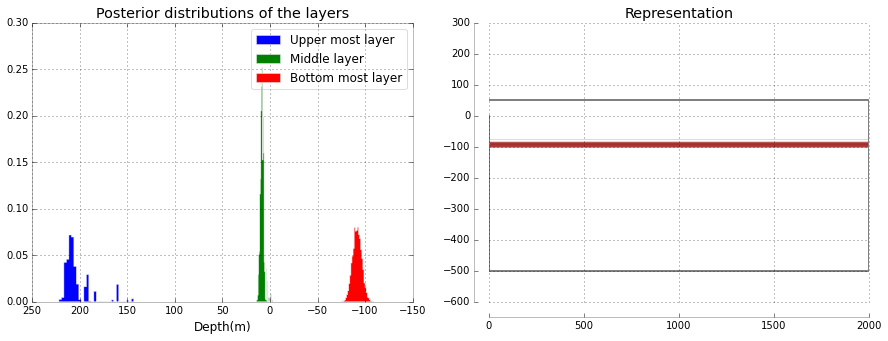

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(alpha_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Upper most layer", normed=True, color = "b")
ax[0].hist(beta_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Middle layer", normed=True, color = "g")
ax[0].hist(gamma_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Bottom most layer", normed=True, color = "r")


ax[0].invert_xaxis()
ax[0].legend()
ax[0].set_title(r"""Posterior distributions of the layers""")
ax[0].set_xlabel("Depth(m)")


ax[1].set_title("Representation")
ax[1].set_xlim([0,2000])
for alpha, beta, gamma in parameters:
    #print alpha, beta, gamma
    model_parameters = {'faults' : {'fault_w_pos' : (0,0.),
                                    'fault_w_dip' : 0,
                                    'fault_e_pos' : (0.,0.),
                                    'fault_e_dip' : 0.},
                        'layers' : {3 : {'w' :(250., -200.),
                                         
                                                 'c' : (1000., -400.),
                                                 'e' : (1750., alpha)},
                                    2 : {'w' :(250., -400.),
                                                 'c' : (1000., -600.),
                                                 'e' : (1750., beta)},
                                    1 : {'w' :(250., -600.),
                                                 'c' : (1000., -800.),
                                                 'e' : (1750., gamma)}},
                        'layer_dip' : 0.000001,
                        'layer_colors' : {1 : 'Brown', 2 : 'g', 3 : 'b'},
                        'width' : 2000., # [m]
                        'height' : 500. # [m]
                        }
    GM = gs.GrabenModel(model_parameters)
    GM.plot_model(ax = ax[1], plot_faults= False, plot_points= False, alpha = 0.3) # Need to make it transparent!!!

## Basic model all posibilities

#### Surface:

(4L,)


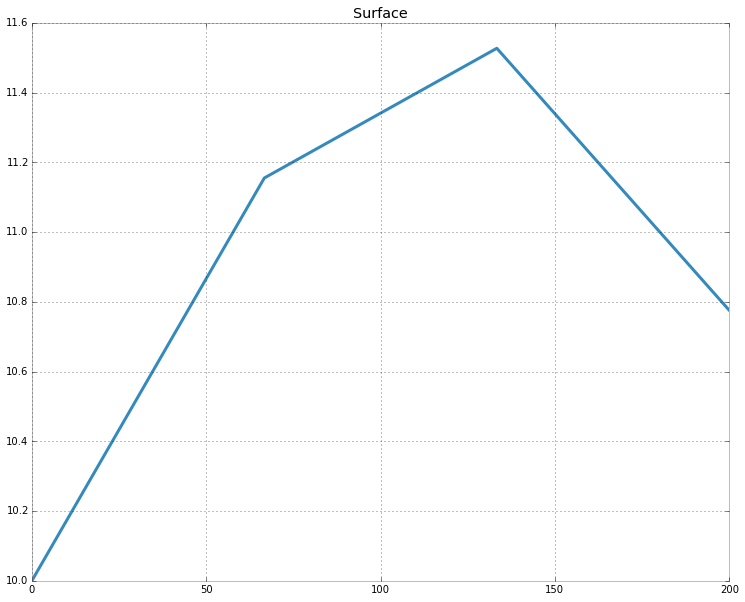

In [15]:
alpha_position_x = np.linspace(0,200,4)
alpha_position_y = np.ones(4)*10
print np.shape(alpha_position_x)
for i in range(1, 4):
    alpha_position_y[i] = pm.rnormal(alpha_position_y[i - 1], 2)
plt.plot(alpha_position_x, alpha_position_y, lw=3)
plt.title("Surface")

###Model

In [13]:
#Priors

alpha = pm.Normal("alpha", 0, 0.5)

thickness_layer1 = pm.Normal("thickness_layer1", 200, 0.005) # a lot of uncertainty so the constrains are necessary
thickness_layer2 = pm.Normal("thickness_layer2", 100, 0.005)

offset = pm.Normal("offset", 500, 0.005)
layer_dip = pm.Normal("layer_dip", 5, 0.05)

fault_e_dip = pm.Normal("fault_e_dip", -70, 0.005, value = -70)
fault_w_dip = pm.Normal("fault_w_dip", 70, 0.005, value = 70)

observed = pm.Normal("obs", alpha, 0.1,  value = alpha_position_y, observed = True)

@pm.deterministic
def beta(alpha = alpha, thickness_layer1 = thickness_layer1):
    return alpha - thickness_layer1


@pm.deterministic
def gamma(beta = beta, thickness_layer2 = thickness_layer2):
    return beta - thickness_layer2

# Constraints -> probability

@pm.potential
def offset_negative_constraint(offset = offset):
    if offset < 0:
        return -np.inf
    return 0

@pm.potential
def faults_limits(fault_e_dip = fault_e_dip, fault_w_dip = fault_w_dip):
    if fault_e_dip < -90 or fault_w_dip > 90 :
        return -np.inf
    if fault_e_dip > 0 or fault_w_dip < 0:
        return -np.inf
    return 0


@pm.potential
def offset_below_faults_constraint(fault_e_dip = fault_e_dip, fault_w_dip = fault_w_dip,
                                   offset = offset, beta =  beta, gamma = gamma):
    fault_intersect = 1100/(np.tan(np.radians(90+fault_e_dip))+np.tan(np.radians(90-fault_w_dip)))       #1100 Distance of the faults at surface for now

#    print "fault",fault_intersect
 #   print  "layers", fault_intersect-offset-gamma, fault_intersect-offset-beta
    if (fault_intersect-offset-beta) < 0 or (fault_intersect-offset-gamma) < 0:
        return -np.inf
    else:
        return 0



#MODEL!!
model = pm.Model([alpha, beta, gamma, thickness_layer1, thickness_layer2,
                  offset, layer_dip, fault_e_dip, fault_w_dip, 
                  faults_limits, offset_negative_constraint, offset_below_faults_constraint,observed])

NameError: name 'alpha_position_y' is not defined

### Simulation

In [18]:
M = pm.MCMC(model)
M.sample(iter=1000)
from pymc import graph

a = graph.dag(M)
a.write_png("Allparameters.png")

 [-----------------100%-----------------] 1000 of 1000 complete in 0.5 sec

True

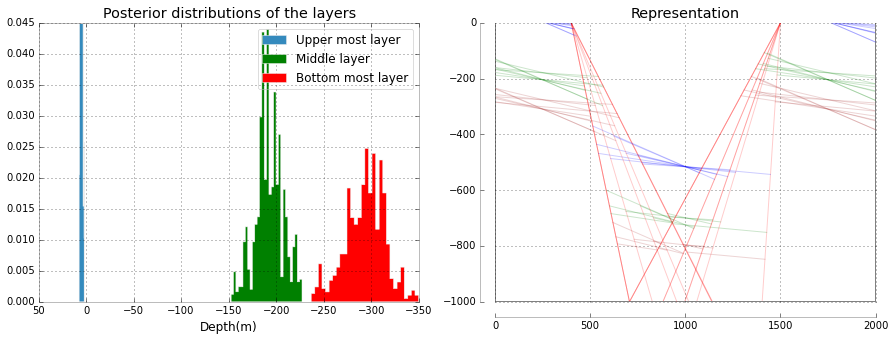

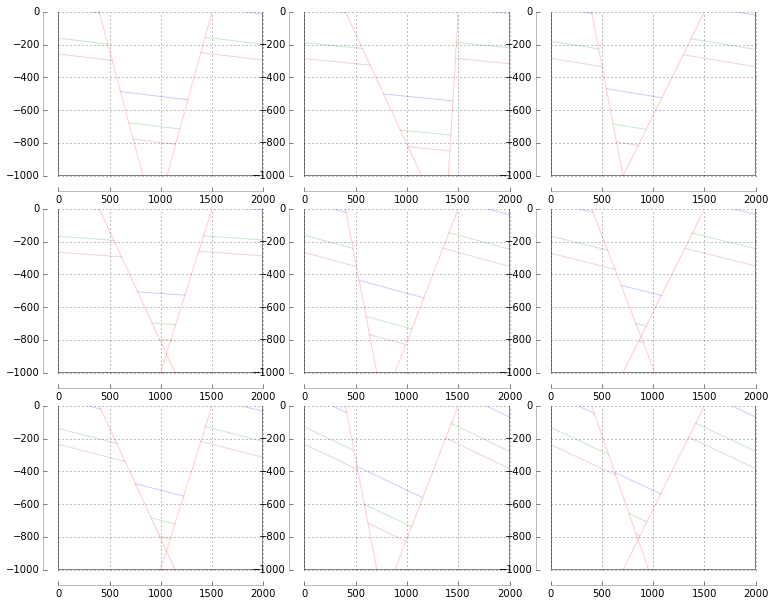

In [21]:
s = -9

gamma_samples, gamma_samples_all = M.trace('gamma')[s:], M.trace('gamma')[:]
alpha_samples, alpha_samples_all = M.trace('alpha')[s:], M.trace("alpha")[:]
beta_samples, beta_samples_all = M.trace('beta')[s:], M.trace("beta")[:]
offset_samples, offset_samples_all = M.trace("offset")[s:], M.trace("offset")[:]
layer_dip, layer_dip_all = M.trace("layer_dip")[s:], M.trace("layer_dip")
fault_e_dip, fault_e_dip_all = M.trace("fault_e_dip")[s:], M.trace("fault_e_dip")
fault_w_dip, fault_w_dip_all = M.trace("fault_w_dip")[s:],M.trace("fault_w_dip")

parameters = zip(alpha_samples, beta_samples, gamma_samples, offset_samples, layer_dip, fault_e_dip, fault_w_dip)
parameters_all = zip(alpha_samples_all, beta_samples_all, gamma_samples_all, offset_samples_all, layer_dip_all, fault_e_dip_all, fault_w_dip_all)





fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(alpha_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Upper most layer", normed=True)
ax[0].hist(beta_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Middle layer", normed=True, color = "g")
ax[0].hist(gamma_samples_all, histtype='stepfilled', bins=30, alpha=1,
         label="Bottom most layer", normed=True, color = "r")


ax[0].invert_xaxis()
ax[0].legend()
ax[0].set_title(r"""Posterior distributions of the layers""")
ax[0].set_xlabel("Depth(m)")


ax[1].set_title("Representation")
ax[1].set_xlim([0,2000])
ax[1].set_ylim([-1000,0])
for  alpha, beta, gamma, offset, layer_dip, fault_e_dip, fault_w_dip in parameters:
    #print alpha, beta, gamma
    model_parameters = {'faults' : {'fault_w_pos' : (400.,0.),
                                'fault_w_dip' : fault_w_dip,
                                'fault_e_pos' : (1500.,0.),
                                'fault_e_dip' : fault_e_dip},
                        'layers' : {3 : {'w' :(250., alpha),
                                                 'c' : (1000., alpha - offset),
                                                 'e' : (1750., alpha)},
                                    2 : {'w' :(250., beta),
                                                 'c' : (1000., beta-offset),
                                                 'e' : (1750., beta)},
                                    1 : {'w' :(250., gamma),
                                                 'c' : (1000., gamma - offset),
                                                 'e' : (1750., gamma)}},
                        'layer_dip' : layer_dip,
                        'layer_colors' : {1 : 'Brown', 2 : 'g', 3 : 'b'},
                        'width' : 2000., # [m]
                        'height' : 1000. # [m]
                        }
    GM = gs.GrabenModel(model_parameters)
    GM.plot_model(ax = ax[1], plot_faults= True , plot_points= False, alpha = 0.3) # Need to make it transparent!!!
    
    
i = 0
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True)

for alpha, beta, gamma, offset, layer_dip, fault_e_dip, fault_w_dip  in parameters:
    plot_figure(alpha, beta, gamma, offset, layer_dip, fault_e_dip, fault_w_dip, axs[i- 3*(i/3),i/3])
    axs[i- 3*(i/3),i/3].set_xlim([0,2000])
    axs[i- 3*(i/3),i/3].set_ylim([-1000,0])
    i += 1

Plotting thickness_layer1
Plotting thickness_layer2
Plotting alpha
Plotting offset
Plotting fault_w_dip
Plotting beta
Plotting gamma
Plotting fault_e_dip
Plotting layer_dip


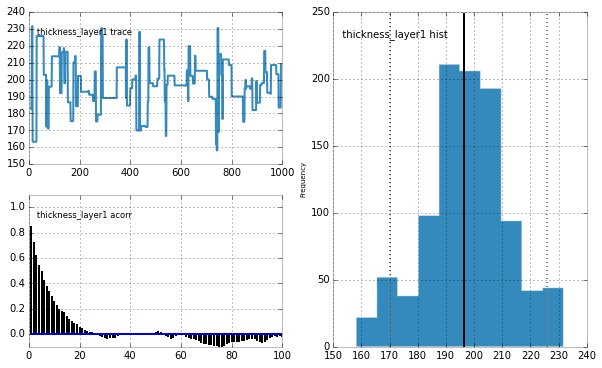

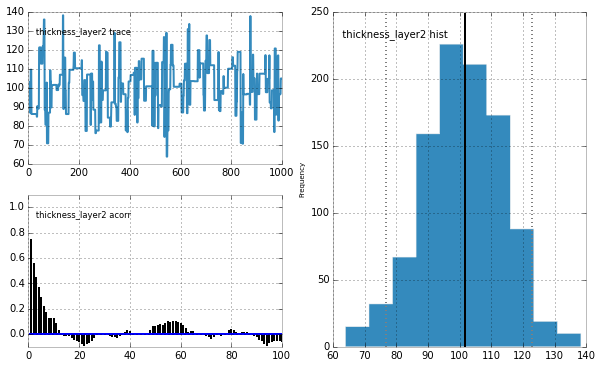

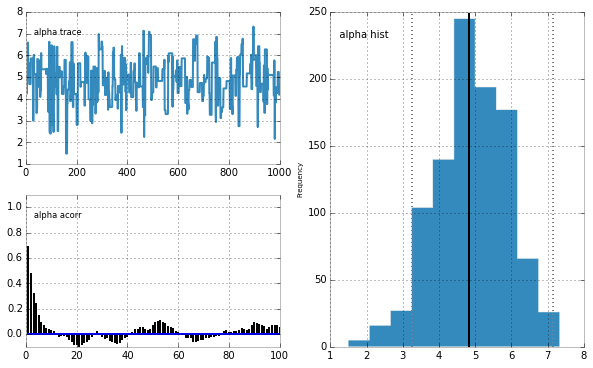

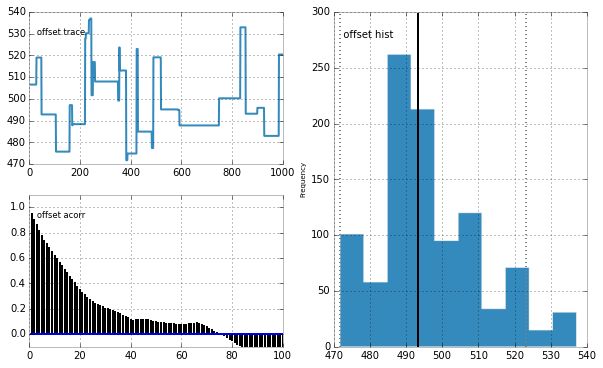

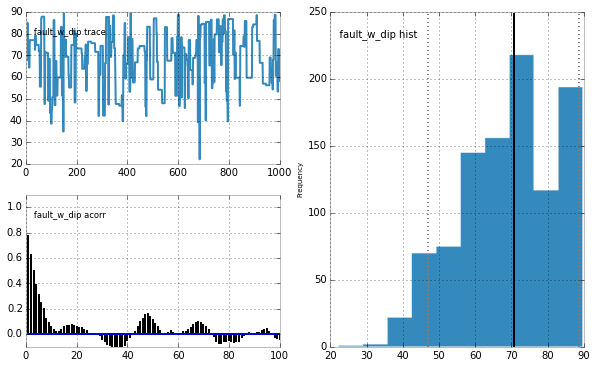

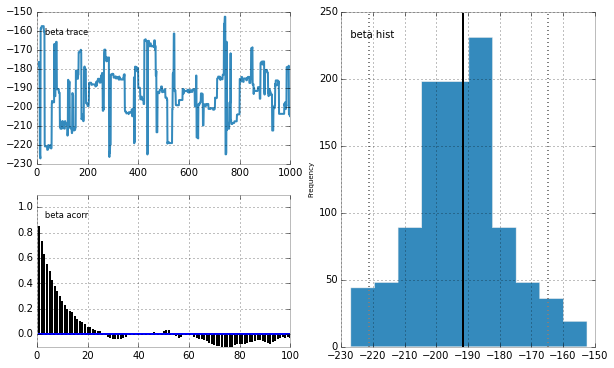

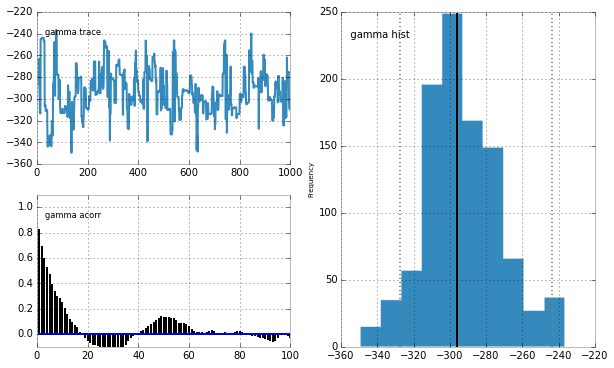

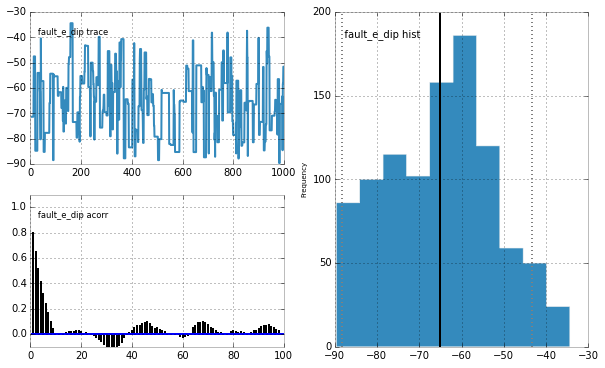

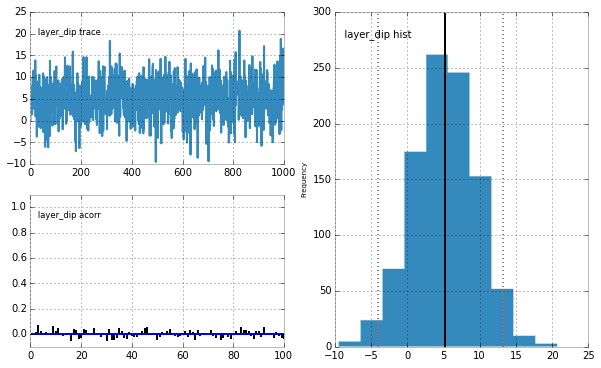

In [22]:
plot(M)